**Input:** 
- UK Biobank cancer-related fields
- ACCEL dataset (Katori et al. 2022)


**Process:**
 - Extract the subset population with ACCEL dataset available
 - See whether cancer makes any difference in ACCEL features

**Output:**


# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
import csv
from datetime import datetime
import os
import numpy as np
import pandas as pd
from pathlib import Path
import polars as pl
import re
from matplotlib import pyplot as plt

from scipy import stats

import statsmodels.api as sm

from contextlib import redirect_stdout
from io import StringIO

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Draw flowcharts using Mermaid
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))


dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


In [2]:
DIR_SOURCE = os.path.join("data", "accel_ukbb", "split")
DIR_OUT = os.path.join("analysis", "specific", "analysis_20230427_01_ACCEL_cancer")

if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

In [3]:
mm("""
graph TD;
    UKBB[UKBB population: 502,386] --> ACCEL[ACCEL data available: 81,496];
    ACCEL --> C1[cancer record after accelerometry: 6,098];
    ACCEL --> C2[cancer record before accelerometry: 11,684];
    ACCEL --> C3[no cancer record: 63,714];
""")


## Functions

In [4]:
def merge_files(list_files, dir):
    list_files = [os.path.join(dir, file) for file in list_files]

    # Initialize an empty DataFrame
    df_merged = pl.DataFrame()
    
    print(datetime.now(), "Start processing", len(list_files), "files")

    # Loop over each file in the list and add it to the merged DataFrame
    for i, file in enumerate(list_files):
        func_print(i + 1)
        # Read in the current file as a DataFrame
        df_current = pl.read_csv(file, sep="\t")

        # Get the column name for the current file's specific column
        column_name = os.path.splitext(os.path.basename(file))[0]

        # Rename the specific column to the name of the current file
        #df_current = df_current.rename(columns={df_current.columns[1]: column_name})
        df_current = df_current.rename({df_current.columns[1]: column_name})

        # If this is the first file being added, simply set df_merged to df_current
        if df_merged.shape == (0, 0):
            df_merged = df_current

        # Otherwise, merge df_current with df_merged on the "eid" column
        else:
            df_merged = df_merged.join(df_current, on="eid", how="outer")

    return df_merged
    
    

def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")

# Merge the relevant fields

In [6]:
list_files = [
"ukb671006_22286_40005-0.0.txt",
"ukb671006_22287_40005-1.0.txt",
"ukb671006_22288_40005-2.0.txt",
"ukb671006_22289_40005-3.0.txt",
"ukb671006_22290_40005-4.0.txt",
"ukb671006_22291_40005-5.0.txt",
"ukb671006_22292_40005-6.0.txt",
"ukb671006_22293_40005-7.0.txt",
"ukb671006_22294_40005-8.0.txt",
"ukb671006_22295_40005-9.0.txt",
"ukb671006_22296_40005-10.0.txt",
"ukb671006_22297_40005-11.0.txt",
"ukb671006_22298_40005-12.0.txt",
"ukb671006_22299_40005-13.0.txt",
"ukb671006_22300_40005-14.0.txt",
"ukb671006_22301_40005-15.0.txt",
"ukb671006_22302_40005-16.0.txt",
"ukb671006_22303_40005-17.0.txt",
"ukb671006_22304_40005-18.0.txt",
"ukb671006_22305_40005-19.0.txt",
"ukb671006_22306_40005-20.0.txt",
"ukb671006_22307_40005-21.0.txt",
"ukb671006_24430_90010-0.0.txt",
"ukb671006_28448_eid_old.txt",
"ukb671006_28449_day_num.txt",
"ukb671006_28450_ST_long_mean.txt",
"ukb671006_28451_ST_long_sd.txt",
"ukb671006_28452_WT_long_mean.txt",
"ukb671006_28453_WT_long_sd.txt",
"ukb671006_28454_ST_short_mean.txt",
"ukb671006_28455_ST_short_sd.txt",
"ukb671006_28456_WT_short_mean.txt",
"ukb671006_28457_WT_short_sd.txt",
"ukb671006_28458_long_window_len_mean.txt",
"ukb671006_28459_long_window_len_sd.txt",
"ukb671006_28460_long_window_num_mean.txt",
"ukb671006_28461_long_window_num_sd.txt",
"ukb671006_28462_short_window_len_mean.txt",
"ukb671006_28463_short_window_len_sd.txt",
"ukb671006_28464_short_window_num_mean.txt",
"ukb671006_28465_short_window_num_sd.txt",
"ukb671006_28466_phase_mean.txt",
"ukb671006_28467_phase_sd.txt",
"ukb671006_28468_max_period.txt",
"ukb671006_28469_amplitude.txt",
"ukb671006_28470_sleep_percentage.txt",
"ukb671006_28471_continuous_day.txt",
"ukb671006_28472_age.txt",
"ukb671006_28473_sex.txt",
"ukb671006_28474_cluster.txt",
"ukb671006_28475_group_eid_old.txt",
"ukb671006_28476_abnormal_group_eid_old.txt",
"ukb671006_28479_cluster_alphabet.txt",
"ukb671006_28480_group_five.txt",
"ukb671006_28481_group_eight.txt",
"ukb671006_28482_abnormal_group_eight.txt",]
df = merge_files(list_files, DIR_SOURCE)

2023-04-24 11:47:45.471587 Start processing 56 files
2023-04-24 11:47:45: 1
2023-04-24 11:47:47: 2
2023-04-24 11:47:51: 3
2023-04-24 11:47:57: 4
2023-04-24 11:48:02: 5
2023-04-24 11:48:06: 6
2023-04-24 11:48:12: 7
2023-04-24 11:48:16: 8
2023-04-24 11:48:21: 9
2023-04-24 11:48:25: 10
2023-04-24 11:49:08: 20
2023-04-24 11:49:58: 30
2023-04-24 11:50:59: 40
2023-04-24 11:51:46: 50


In [7]:
df

shape: (502386, 57)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_22 ┆ ukb671006_22 ┆ ... ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 │
│ ---     ┆ 22286_4000 ┆ 287_40005-1. ┆ 288_40005-2. ┆     ┆ 479_cluster_ ┆ 480_group_fi ┆ 481_group_ei ┆ 482_abnormal │
│ i64     ┆ 5-0.0      ┆ 0            ┆ 0            ┆     ┆ alphabet     ┆ ve           ┆ ght          ┆ _group_e...  │
│         ┆ ---        ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│         ┆ str        ┆ str          ┆ str          ┆     ┆ str          ┆ str          ┆ str          ┆ str          │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000010 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 1000028 ┆ 2008-05-13 ┆ 2017-02-02   ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 1000034 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 1000045 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024804 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 6024818 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ A            ┆ 1            ┆ A            ┆ NA           │
│ 6024820 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
│ 6024833 ┆ NA         ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ NA           │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 40626 characters

# Date of cancer diagnosis
- Calculate the earliest date of cancer diagnosis
- Flag whether the cancer diagnosis is before or after the accelerometry measurement

In [8]:
cols_cancer_date = [
"ukb671006_22286_40005-0.0", 
"ukb671006_22287_40005-1.0", 
"ukb671006_22288_40005-2.0", 
"ukb671006_22289_40005-3.0", 
"ukb671006_22290_40005-4.0", 
"ukb671006_22291_40005-5.0", 
"ukb671006_22292_40005-6.0", 
"ukb671006_22293_40005-7.0", 
"ukb671006_22294_40005-8.0", 
"ukb671006_22295_40005-9.0", 
"ukb671006_22296_40005-10.0", 
"ukb671006_22297_40005-11.0", 
"ukb671006_22298_40005-12.0", 
"ukb671006_22299_40005-13.0", 
"ukb671006_22300_40005-14.0", 
"ukb671006_22301_40005-15.0", 
"ukb671006_22302_40005-16.0", 
"ukb671006_22303_40005-17.0", 
"ukb671006_22304_40005-18.0", 
"ukb671006_22305_40005-19.0", 
"ukb671006_22306_40005-20.0", 
"ukb671006_22307_40005-21.0", 
]

# convert the columns to Date
for i_col in cols_cancer_date:
    df = df.with_columns(pl.col(i_col).str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False))
    
# calculate the earliest date for each row
earliest_cancer = df[cols_cancer_date].min(axis=1)

# Preserve only the earliest date
df = df.with_column(earliest_cancer.alias("earliest_cancer")).drop(cols_cancer_date)

# Convert the row "ukb671006_24430_90010-0.0"
#    (ACCEL date stored in UKBiobank)
#    to date format

# Define the custom date conversion function
def convert_date_format(date_str: str) -> str:
    if date_str == "NA":
        formatted_date = "NA"
    else:
        date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
        formatted_date = date_obj.strftime("%Y-%m-%d")
    return formatted_date


# Apply the custom function to the "ukb671006_24430_90010-0.0" column
df = (df.with_column(
    pl.col("ukb671006_24430_90010-0.0")
    .apply(convert_date_format, return_dtype=pl.Utf8)
    .str.strptime(pl.Date, fmt="%Y-%m-%d", strict=False)
    .alias("ukb671006_24430_90010-0.0")
))

df

shape: (502386, 36)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ ukb671006_28 ┆ ukb671006_28 ┆ ukb671006_28 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ 480_group_fi ┆ 481_group_ei ┆ 482_abnormal ┆ cer          │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ve           ┆ ght          ┆ _group_e...  ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ ---          ┆ ---          ┆ ---          ┆ date         │
│         ┆ date       ┆              ┆              ┆     ┆ str          ┆ str          ┆ str          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000010 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 1000028 ┆ 2014-10-31 ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ 2008-05-13   │
│ 1000034 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 1000045 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024804 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 6024818 ┆ 2014-11-15 ┆ 6016103      ┆ 3.0          ┆ ... ┆ 1            ┆ A            ┆ NA           ┆ null         │
│ 6024820 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
│ 6024833 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ NA           ┆ NA           ┆ NA           ┆ null         │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 25574 characters

In [9]:
# Define a function to convert the date string into a single integer
def date_string_to_int(date_str):
    if not date_str:
        result = "NA"
    else:
        date_start = datetime.strptime("1970-10-10", '%Y-%m-%d').date()
        result = (date_str - date_start).days
    return result


accel_after_cancer = (df['ukb671006_24430_90010-0.0'] > df['earliest_cancer']).cast(pl.Boolean)

df_annotated = (df
                .with_column(accel_after_cancer.alias("accel_after_cancer"))
                .with_columns(pl.col('ukb671006_24430_90010-0.0')
                              .apply(date_string_to_int)
                              .alias("ukb671006_24430_90010-0.0_days")
                              .cast(pl.Int32, strict=False)
                             )
                .with_columns(pl.col('earliest_cancer')
                              .apply(date_string_to_int)
                              .alias("earliest_cancer_days")
                              .cast(pl.Int32, strict=False)
                             )                              
               )
df_annotated

shape: (502386, 39)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ date         ┆ bool         ┆ ---          ┆ i32          │
│         ┆ date       ┆              ┆              ┆     ┆              ┆              ┆ i32          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000010 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 1000028 ┆ 2014-10-31 ┆ NA           ┆ NA           ┆ ... ┆ 2008-05-13   ┆ true         ┆ 16092        ┆ 13730        │
│ 1000034 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 1000045 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024804 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 6024818 ┆ 2014-11-15 ┆ 6016103      ┆ 3.0          ┆ ... ┆ null         ┆ null         ┆ 16107        ┆ null         │
│ 6024820 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
│ 6024833 ┆ null       ┆ NA           ┆ NA           ┆ ... ┆ null         ┆ null         ┆ null         ┆ null         │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 26931 characters

In [10]:
FILE_OUT = os.path.join(DIR_OUT, "filtered_annotated.csv")
df_annotated.write_csv(FILE_OUT)

# Comparison of "accelerometry before/after/without cancer" - overall chisq/t-test

In [3]:
file = os.path.join(DIR_OUT, "filtered_annotated.csv")
df_annotated = (pl.read_csv(file, infer_schema_length=None)
               .filter(pl.col("ukb671006_28448_eid_old") != "NA")
               )
df_annotated

shape: (81496, 39)
┌─────────┬────────────┬──────────────┬──────────────┬─────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_ ┆ ukb671006_28 ┆ ukb671006_28 ┆ ... ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 24430_9001 ┆ 448_eid_old  ┆ 449_day_num  ┆     ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0-0.0      ┆ ---          ┆ ---          ┆     ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---        ┆ str          ┆ str          ┆     ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str        ┆              ┆              ┆     ┆              ┆              ┆ i64          ┆              │
╞═════════╪════════════╪══════════════╪══════════════╪═════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000076 ┆ 2014-03-17 ┆ 3705388      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 15864        ┆ null         │
│ 1000091 ┆ 2015-06-27 ┆ 3867761      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 16331        ┆ null         │
│ 1000162 ┆ 2015-01-28 ┆ 3077861      ┆ 4.0          ┆ ... ┆ null         ┆ null         ┆ 16181        ┆ null         │
│ 1000171 ┆ 2014-09-26 ┆ 5292419      ┆ 5.0          ┆ ... ┆ null         ┆ null         ┆ 16057        ┆ null         │
│ ...     ┆ ...        ┆ ...          ┆ ...          ┆ ... ┆ ...          ┆ ...          ┆ ...          ┆ ...          │
│ 6024605 ┆ 2013-08-02 ┆ 1910696      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 15637        ┆ null         │
│ 6024698 ┆ 2013-07-22 ┆ 1252952      ┆ 5.0          ┆ ... ┆ null         ┆ null         ┆ 15626        ┆ null         │
│ 6024737 ┆ 2014-06-09 ┆ 4741522      ┆ 6.0          ┆ ... ┆ null         ┆ null         ┆ 15948        ┆ null         │
│ 6024818 ┆ 2014-11-15 ┆ 6016103      ┆ 3.0          ┆ ... ┆ null         ┆ null         ┆ 16107        ┆ null         │
└─────────┴────────────┴──────────────┴──────────────┴─────┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 5000 exceeded with 30087 characters

In [4]:
df_accel_before_cancer = df_annotated.filter(pl.col("accel_after_cancer") == False)
df_accel_after_cancer = df_annotated.filter(pl.col("accel_after_cancer") == True)
df_accel_with_cancer = df_annotated.filter(pl.col("accel_after_cancer").is_not_null())
df_accel_without_cancer = df_annotated.filter(pl.col("accel_after_cancer").is_null())

In [5]:
df_accel_after_cancer

shape: (11_684, 39)
┌─────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_24 ┆ ukb671006_28 ┆ ukb671006_28 ┆ … ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 430_90010-0. ┆ 448_eid_old  ┆ 449_day_num  ┆   ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0            ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---          ┆ str          ┆ str          ┆   ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str          ┆              ┆              ┆   ┆              ┆              ┆ i64          ┆              │
╞═════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1001184 ┆ 2015-11-20   ┆ 4024816      ┆ 6.0          ┆ … ┆ 2007-02-23   ┆ true         ┆ 16477        ┆ 13285        │
│ 1001439 ┆ 2015-03-21   ┆ 1238327      ┆ 6.0          ┆ … ┆ 2001-03-30   ┆ true         ┆ 16233        ┆ 11129        │
│ 1001725 ┆ 2014-10-17   ┆ 2583344      ┆ 6.0          ┆ … ┆ 2010-11-24   ┆ true         ┆ 16078        ┆ 14655        │
│ 1001889 ┆ 2015-10-14   ┆ 4665024      ┆ 6.0          ┆ … ┆ 2000-08-22   ┆ true         ┆ 16440        ┆ 10909        │
│ …       ┆ …            ┆ …            ┆ …            ┆ … ┆ …            ┆ …            ┆ …            ┆ …            │
│ 6021735 ┆ 2015-01-28   ┆ 5582309      ┆ 6.0          ┆ … ┆ 2011-08-03   ┆ true         ┆ 16181        ┆ 14907        │
│ 6022189 ┆ 2014-09-20   ┆ 1182093      ┆ 6.0          ┆ … ┆ 1996-08-06   ┆ true         ┆ 16051        ┆ 9432         │
│ 6023069 ┆ 2015-09-26   ┆ 4069378      ┆ 6.0          ┆ … ┆ 2007-06-18   ┆ true         ┆ 16422        ┆ 13400        │
│ 6023283 ┆ 2014-04-16   ┆ 5906221      ┆ 6.0          ┆ … ┆ 2011-08-19   ┆ true         ┆ 15894        ┆ 14923        │
└─────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 27010 characters

In [6]:
df_accel_before_cancer

shape: (6_098, 39)
┌─────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_24 ┆ ukb671006_28 ┆ ukb671006_28 ┆ … ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 430_90010-0. ┆ 448_eid_old  ┆ 449_day_num  ┆   ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0            ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---          ┆ str          ┆ str          ┆   ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str          ┆              ┆              ┆   ┆              ┆              ┆ i64          ┆              │
╞═════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000337 ┆ 2014-11-15   ┆ 5579755      ┆ 6.0          ┆ … ┆ 2016-04-04   ┆ false        ┆ 16107        ┆ 16613        │
│ 1002455 ┆ 2013-07-20   ┆ 4988731      ┆ 6.0          ┆ … ┆ 2019-02-09   ┆ false        ┆ 15624        ┆ 17654        │
│ 1002651 ┆ 2013-07-20   ┆ 2962276      ┆ 6.0          ┆ … ┆ 2014-06-17   ┆ false        ┆ 15624        ┆ 15956        │
│ 1002720 ┆ 2014-11-15   ┆ 2112328      ┆ 6.0          ┆ … ┆ 2018-07-28   ┆ false        ┆ 16107        ┆ 17458        │
│ …       ┆ …            ┆ …            ┆ …            ┆ … ┆ …            ┆ …            ┆ …            ┆ …            │
│ 6019212 ┆ 2014-09-20   ┆ 5292311      ┆ 6.0          ┆ … ┆ 2018-09-06   ┆ false        ┆ 16051        ┆ 17498        │
│ 6021036 ┆ 2013-10-24   ┆ 2219450      ┆ 6.0          ┆ … ┆ 2018-04-20   ┆ false        ┆ 15720        ┆ 17359        │
│ 6022983 ┆ 2015-09-21   ┆ 3937382      ┆ 6.0          ┆ … ┆ 2017-03-16   ┆ false        ┆ 16417        ┆ 16959        │
│ 6023473 ┆ 2015-05-15   ┆ 4653033      ┆ 6.0          ┆ … ┆ 2018-05-21   ┆ false        ┆ 16288        ┆ 17390        │
└─────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 27028 characters

In [7]:
df_accel_with_cancer

shape: (17_782, 39)
┌─────────┬──────────────┬──────────────┬──────────────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ eid     ┆ ukb671006_24 ┆ ukb671006_28 ┆ ukb671006_28 ┆ … ┆ earliest_can ┆ accel_after_ ┆ ukb671006_24 ┆ earliest_can │
│ ---     ┆ 430_90010-0. ┆ 448_eid_old  ┆ 449_day_num  ┆   ┆ cer          ┆ cancer       ┆ 430_90010-0. ┆ cer_days     │
│ i64     ┆ 0            ┆ ---          ┆ ---          ┆   ┆ ---          ┆ ---          ┆ 0_days       ┆ ---          │
│         ┆ ---          ┆ str          ┆ str          ┆   ┆ str          ┆ bool         ┆ ---          ┆ i64          │
│         ┆ str          ┆              ┆              ┆   ┆              ┆              ┆ i64          ┆              │
╞═════════╪══════════════╪══════════════╪══════════════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 1000337 ┆ 2014-11-15   ┆ 5579755      ┆ 6.0          ┆ … ┆ 2016-04-04   ┆ false        ┆ 16107        ┆ 16613        │
│ 1001184 ┆ 2015-11-20   ┆ 4024816      ┆ 6.0          ┆ … ┆ 2007-02-23   ┆ true         ┆ 16477        ┆ 13285        │
│ 1001439 ┆ 2015-03-21   ┆ 1238327      ┆ 6.0          ┆ … ┆ 2001-03-30   ┆ true         ┆ 16233        ┆ 11129        │
│ 1001725 ┆ 2014-10-17   ┆ 2583344      ┆ 6.0          ┆ … ┆ 2010-11-24   ┆ true         ┆ 16078        ┆ 14655        │
│ …       ┆ …            ┆ …            ┆ …            ┆ … ┆ …            ┆ …            ┆ …            ┆ …            │
│ 6022983 ┆ 2015-09-21   ┆ 3937382      ┆ 6.0          ┆ … ┆ 2017-03-16   ┆ false        ┆ 16417        ┆ 16959        │
│ 6023069 ┆ 2015-09-26   ┆ 4069378      ┆ 6.0          ┆ … ┆ 2007-06-18   ┆ true         ┆ 16422        ┆ 13400        │
│ 6023283 ┆ 2014-04-16   ┆ 5906221      ┆ 6.0          ┆ … ┆ 2011-08-19   ┆ true         ┆ 15894        ┆ 14923        │
│ 6023473 ┆ 2015-05-15   ┆ 4653033      ┆ 6.0          ┆ … ┆ 2018-05-21   ┆ false        ┆ 16288        ┆ 17390        │
└─────────┴──────────────┴──────────────┴──────────────┴───┴──────────────┴──────────────┴──────────────┴──────────────┘

limit_output extension: Maximum message size of 10000 exceeded with 26966 characters

In [8]:
df_accel_without_cancer

eid,ukb671006_24430_90010-0.0,ukb671006_28448_eid_old,ukb671006_28449_day_num,ukb671006_28450_ST_long_mean,ukb671006_28451_ST_long_sd,ukb671006_28452_WT_long_mean,ukb671006_28453_WT_long_sd,ukb671006_28454_ST_short_mean,ukb671006_28455_ST_short_sd,ukb671006_28456_WT_short_mean,ukb671006_28457_WT_short_sd,ukb671006_28458_long_window_len_mean,ukb671006_28459_long_window_len_sd,ukb671006_28460_long_window_num_mean,ukb671006_28461_long_window_num_sd,ukb671006_28462_short_window_len_mean,ukb671006_28463_short_window_len_sd,ukb671006_28464_short_window_num_mean,ukb671006_28465_short_window_num_sd,ukb671006_28466_phase_mean,ukb671006_28467_phase_sd,ukb671006_28468_max_period,ukb671006_28469_amplitude,ukb671006_28470_sleep_percentage,ukb671006_28471_continuous_day,ukb671006_28472_age,ukb671006_28473_sex,ukb671006_28474_cluster,ukb671006_28475_group_eid_old,ukb671006_28476_abnormal_group_eid_old,ukb671006_28479_cluster_alphabet,ukb671006_28480_group_five,ukb671006_28481_group_eight,ukb671006_28482_abnormal_group_eight,earliest_cancer,accel_after_cancer,ukb671006_24430_90010-0.0_days,earliest_cancer_days
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,i64,i64
1000076,"""2014-03-17""","""3705388""","""6.0""","""408.0833333333…","""83.08450350229…","""53.91666666666…","""22.49891972715…","""34.66666666666…","""55.54177606890…","""2.833333333333…","""4.624812308503…","""462.0""","""93.65183749754…","""1.0""","""0.0""","""56.25""","""49.82030208659…","""0.666666666666…","""0.745355992499…","""960.75""","""35.79658968859…","""1439.999999999…","""0.641583920993…","""0.307754629629…","""6.0""","""69""","""0""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,15864,null
1000091,"""2015-06-27""","""3867761""","""6.0""","""215.3333333333…","""98.56624957639…","""23.0""","""14.30908802125…","""73.33333333333…","""83.99338598299…","""22.91666666666…","""27.38067546443…","""286.0""","""29.75903224232…","""0.833333333333…","""0.372677996249…","""36.09375""","""38.21003580131…","""2.666666666666…","""1.699673171197…","""960.4166666666…","""58.07855073566…","""1421.999999999…","""0.477603314889…","""0.207349537037…","""6.0""","""67""","""1""","""1_0""","""3b""","""NA""","""C""","""3""","""E""","""NA""",null,null,16331,null
1000162,"""2015-01-28""","""3077861""","""4.0""","""512.375""","""45.02273731127…","""110.625""","""56.50594548363…","""39.125""","""38.66421957055…","""18.75""","""21.18519530238…","""623.0""","""99.46041926314…","""1.0""","""0.0""","""46.3""","""35.20596540360…","""1.25""","""1.089724735885…","""926.75""","""6.675514961409…","""1439.999999999…","""0.740724781467…","""0.392534722222…","""4.0""","""51""","""1""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,16181,null
1000171,"""2014-09-26""","""5292419""","""5.0""","""461.3""","""56.67503859725…","""64.6""","""33.89896753589…","""4.0""","""8.0""","""0.8""","""1.600000000000…","""525.9""","""49.81907265295…","""1.0""","""0.0""","""24.0""","""0.0""","""0.2""","""0.400000000000…","""895.3""","""10.42401074443…","""1439.999999999…","""0.670661740528…","""0.325625""","""5.0""","""59""","""0""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,16057,null
1000196,"""2015-10-22""","""1574881""","""6.0""","""425.75""","""47.03256850311…","""27.91666666666…","""7.683405639573…","""24.5""","""32.60112472497…","""10.66666666666…","""12.17123202017…","""453.6666666666…","""46.80782223327…","""1.0""","""0.0""","""52.75""","""43.49928160326…","""0.666666666666…","""0.471404520791…","""992.75""","""42.70221500890…","""1439.999999999…","""0.655325496636…","""0.318171296296…","""6.0""","""54""","""0""","""2_0""","""4b""","""NA""","""F""","""4""","""G""","""NA""",null,null,16448,null
1000209,"""2014-11-15""","""5256236""","""5.0""","""412.1""","""99.94718605343…","""43.4""","""6.952697318307…","""16.5""","""27.82804340948…","""14.0""",

limit_output extension: Maximum message size of 10000 exceeded with 26413 characters

In [9]:
pheno_list_categorical = [
"ukb671006_28449_day_num",
"ukb671006_28471_continuous_day",
"ukb671006_28473_sex",
"ukb671006_28474_cluster",
"ukb671006_28475_group_eid_old",
"ukb671006_28476_abnormal_group_eid_old",
"ukb671006_28480_group_five",
]

pheno_list_continuous = [
"ukb671006_28450_ST_long_mean",
"ukb671006_28451_ST_long_sd",
"ukb671006_28452_WT_long_mean",
"ukb671006_28453_WT_long_sd",
"ukb671006_28454_ST_short_mean",
"ukb671006_28455_ST_short_sd",
"ukb671006_28456_WT_short_mean",
"ukb671006_28457_WT_short_sd",
"ukb671006_28458_long_window_len_mean",
"ukb671006_28459_long_window_len_sd",
"ukb671006_28460_long_window_num_mean",
"ukb671006_28461_long_window_num_sd",
"ukb671006_28462_short_window_len_mean",
"ukb671006_28463_short_window_len_sd",
"ukb671006_28464_short_window_num_mean",
"ukb671006_28465_short_window_num_sd",
"ukb671006_28466_phase_mean",
"ukb671006_28467_phase_sd",
"ukb671006_28468_max_period",
"ukb671006_28469_amplitude",
"ukb671006_28470_sleep_percentage",
"ukb671006_28472_age",
"ukb671006_24430_90010-0.0_days",
"earliest_cancer_days",
]

# Process categorical variables
def compare_categorical(pheno_list_categorical, df1, df2, label1, label2, DIR_OUT, suffix):
    list_statistics = [["data1", "data2", "suffix", "phenotype", "chi-sq", "p-value"]] # Store the result
    dir_out = os.path.join(DIR_OUT, suffix)
    if not os.path.exists(dir_out):
        os.makedirs(dir_out)
        
    for pheno in pheno_list_categorical:
        print(pheno)
        # List up the frequency of each value in a column of the two dataframes
        freq_before = df1[pheno].value_counts().sort(by=pheno)
        freq_after = df2[pheno].value_counts().sort(by=pheno)

        # Print the frequency of each value
        # Create a contingency table of the frequencies
        cont_table = (freq_before.join(freq_after, on=pheno, how='outer')
                      .to_numpy()[:, 1:])
        cont_table = np.nan_to_num(cont_table.astype(float), nan=0).astype(int)
        #print(cont_table)

        # Perform the chi-squared test of independence
        chi2, p_value, dof, expected = stats.chi2_contingency(cont_table)
        list_statistics.append([label1, label2, suffix, pheno, chi2, p_value])

        # Print the results of the test
        print("p-value:", p_value)

        # Normalize the data by dividing each row by the row sum
        normalized_cont_table = cont_table / cont_table.sum(axis=0)

        if len(freq_before[pheno]) < len(freq_after[pheno]):
            ticks=freq_after[pheno]
        else:
            ticks=freq_before[pheno]
        
        # Create a bar chart of the normalized data
        fig, ax = plt.subplots()
        fig.set_size_inches(4, 3)
        plt.title(pheno)
        ax.bar(np.arange(normalized_cont_table.shape[0]) - 0.2, 
               normalized_cont_table[:, 0], width=0.4, label=label1)
        ax.bar(np.arange(normalized_cont_table.shape[0]) + 0.2,
               normalized_cont_table[:, 1], width=0.4, label=label2)
        ax.set_xticks(np.arange(normalized_cont_table.shape[0]))
        ax.set_xticklabels(ticks, rotation='vertical')
        ax.set_xlabel("Values")
        ax.set_ylabel("Normalized values")
        ax.legend()
        file_out = os.path.join(dir_out, "compare_categorical_" + suffix + "_" + pheno + ".png")
        plt.savefig(file_out, dpi=400)  
        plt.show()

        print()
        
    file_out = os.path.join(dir_out, "compare_categorical_" + suffix + ".csv")
    with open(file_out, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(list_statistics)
        
    return list_statistics

        
# Convert anything to np.float32
def pl_to_float(df):
    result = df.to_numpy()
    try:
        result = result.astype(float)
    except:
        if "-" in result[0]: # Date-time format
            # Convert the date strings to datetime objects
            result = np.array([datetime.fromisoformat(date_str) for date_str in result])

            # Extract the date component and convert to integer
            result = np.array([int(date_obj.timestamp()) for date_obj in result])
    return result


# Check normality
def test_normality(pheno_list_continuous, df):
    pval_min = 1
    for pheno in pheno_list_continuous:
        print(pheno)
        try:
            np_df = pl_to_float(df[pheno])
            pval = stats.kstest(np_df, "norm")[1]
            print("P-value =", pval)
            if not np.isnan(pval):
                pval_min = min(pval, pval_min)
        except:
            print("Skip because the data is not valid ")
    if pval_min < 0.05 / len(pheno_list_continuous):
        is_normal = False
    else:
        is_normal = True
    print()
    print("Minimum p-value = ", pval_min, ", therefore normality =", is_normal)


# Process continuous variables
def compare_continuous(pheno_list_continuous, df1, df2, label1, label2, DIR_OUT, suffix):
    list_statistics = [["data1", "data2", "suffix", "phenotype", "MannWhitneyU-stat", "p-value"]] # Store the result
    dir_out = os.path.join(DIR_OUT, suffix)
    if not os.path.exists(dir_out):
        os.makedirs(dir_out)
        
    for pheno in pheno_list_continuous:
        print(pheno)

        # Calculate mean, median, and standard deviation for the two dataframes
        try:
            np_before = pl_to_float(df1[pheno])
            np_after = pl_to_float(df2[pheno])
            np_before = np_before[~np.isnan(np_before)]
            np_after = np_after[~np.isnan(np_after)]
        except:
            print("Skip because the matching data does not exist in both datasets")
            continue
        
        if len(np_before) < 10:
            print("Skip because the matching data does not exist in both datasets")
            continue
        if len(np_after) < 10:
            print("Skip because the matching data does not exist in both datasets")
            continue
        
        mean_before = np_before.mean()
        median_before = np.median(np_before)
        std_before = np_before.std()

        mean_after = np_after.mean()
        median_after = np.median(np_after)
        std_after = np_after.std()
        
        # Perform a two-sample t-test to test for significant differences between the two distributions
        mann_stat, p_value = stats.mannwhitneyu(np_before, np_after, alternative='two-sided')
        
        list_statistics.append([label1, label2, suffix, pheno, mann_stat, p_value])

        print("p-value:", p_value)

        # Plot the distribution of the pheno column for each dataframe
        plt.figure(figsize=[4, 3])
        plt.hist(np_before, alpha=0.5, label=label1, density=True, bins=100)
        plt.hist(np_after, alpha=0.5, label=label2, density=True, bins=100)
        plt.legend(loc="upper right")
        plt.title(pheno)
        plt.xlabel("Value")
        plt.ylabel("Frequency")

        file_out = os.path.join(dir_out, "compare_continuous_" + suffix + "_" + pheno + ".png")
        plt.savefig(file_out, dpi=400)  

        plt.show()
        
    file_out = os.path.join(dir_out, "compare_continuous_" + suffix + ".csv")
    with open(file_out, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(list_statistics)
        
    return list_statistics

## The datasets do not follow normal distribution

In [11]:
test_normality(pheno_list_continuous, df_accel_before_cancer)
print()
test_normality(pheno_list_continuous, df_accel_after_cancer)
print()
test_normality(pheno_list_continuous, df_accel_without_cancer)

ukb671006_28450_ST_long_mean
P-value = 0.0
ukb671006_28451_ST_long_sd
P-value = 0.0
ukb671006_28452_WT_long_mean
P-value = 0.0
ukb671006_28453_WT_long_sd
P-value = 0.0
ukb671006_28454_ST_short_mean
P-value = 0.0
ukb671006_28455_ST_short_sd
P-value = 0.0
ukb671006_28456_WT_short_mean
P-value = 0.0
ukb671006_28457_WT_short_sd
P-value = 0.0
ukb671006_28458_long_window_len_mean
P-value = 0.0
ukb671006_28459_long_window_len_sd
P-value = 0.0
ukb671006_28460_long_window_num_mean
P-value = 0.0
ukb671006_28461_long_window_num_sd
P-value = 0.0
ukb671006_28462_short_window_len_mean
P-value = 0.0
ukb671006_28463_short_window_len_sd
P-value = 0.0
ukb671006_28464_short_window_num_mean
P-value = 0.0
ukb671006_28465_short_window_num_sd
P-value = 0.0
ukb671006_28466_phase_mean
P-value = 0.0
ukb671006_28467_phase_sd
P-value = 0.0
ukb671006_28468_max_period
P-value = 0.0
ukb671006_28469_amplitude
P-value = 0.0
ukb671006_28470_sleep_percentage
P-value = 0.0
ukb671006_28472_age
P-value = 0.0
ukb671006_2443

ukb671006_28449_day_num
p-value: 0.8171067593880471


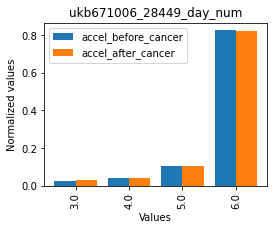


ukb671006_28471_continuous_day
p-value: 0.8567848760513868


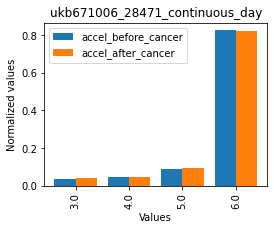


ukb671006_28473_sex
p-value: 1.6118503744238425e-59


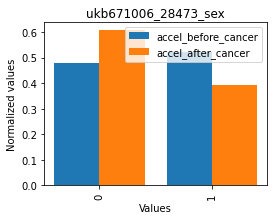


ukb671006_28474_cluster
p-value: 0.46206142412301854


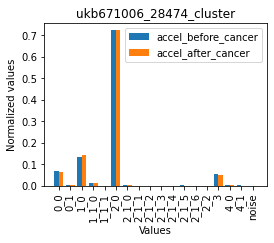


ukb671006_28475_group_eid_old
p-value: 0.09028272458300872


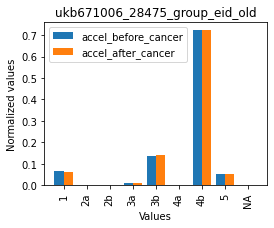


ukb671006_28476_abnormal_group_eid_old
p-value: 0.21104276497484195


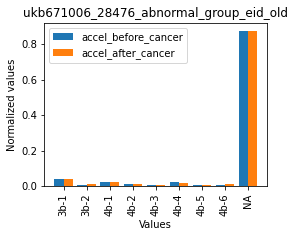


ukb671006_28480_group_five
p-value: 0.1170899068051632


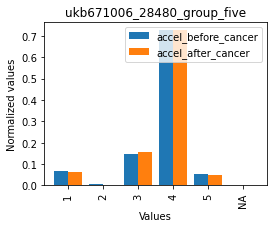

In [20]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_before_cancer, df_accel_after_cancer, 
                    "accel_before_cancer", "accel_after_cancer",
                                      DIR_OUT, "before_after")

ukb671006_28449_day_num
p-value: 2.7443037784254774e-08


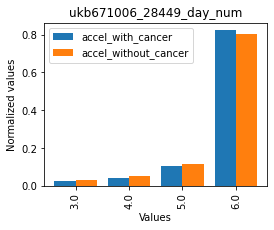


ukb671006_28471_continuous_day
p-value: 6.938576397080346e-09


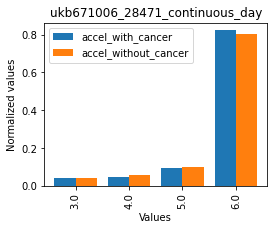


ukb671006_28473_sex
p-value: 0.12836002457427576


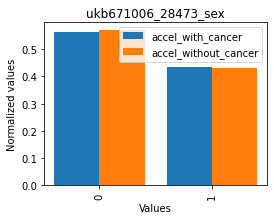


ukb671006_28474_cluster
p-value: 4.422416297189522e-14


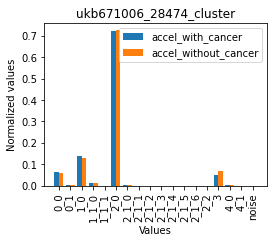


ukb671006_28475_group_eid_old
p-value: 8.466961879142603e-17


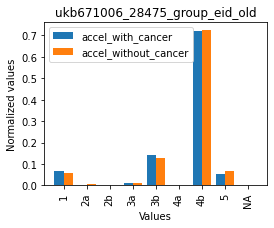


ukb671006_28476_abnormal_group_eid_old
p-value: 5.389878249642532e-08


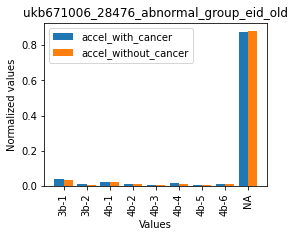


ukb671006_28480_group_five
p-value: 2.0069817260884273e-17


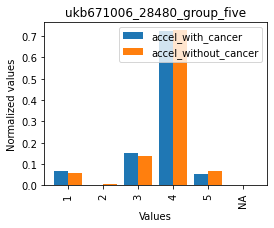

In [21]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_with_cancer, df_accel_without_cancer, 
                    "accel_with_cancer", "accel_without_cancer",
                                     DIR_OUT, "with_without")

ukb671006_28449_day_num
p-value: 0.0003633525940662679


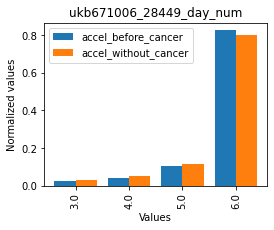


ukb671006_28471_continuous_day
p-value: 0.00019961636037819065


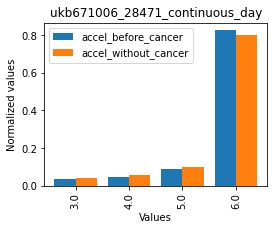


ukb671006_28473_sex
p-value: 6.988449211101014e-42


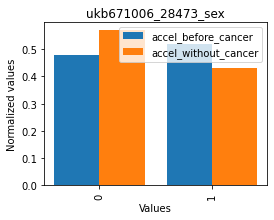


ukb671006_28474_cluster
p-value: 0.00033169697625045046


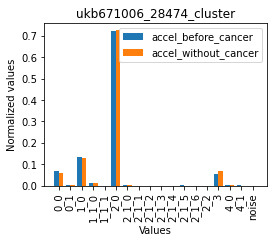


ukb671006_28475_group_eid_old
p-value: 1.1053747224001379e-05


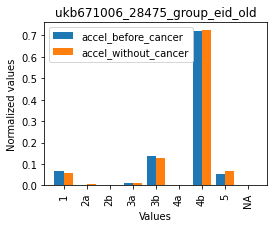


ukb671006_28476_abnormal_group_eid_old
p-value: 0.0004029354025918469


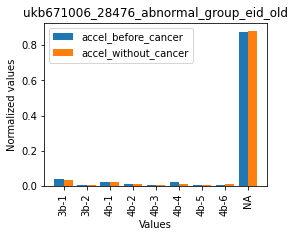


ukb671006_28480_group_five
p-value: 3.662836129630427e-05


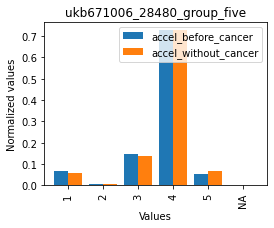

In [22]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_before_cancer, df_accel_without_cancer, 
                    "accel_before_cancer", "accel_without_cancer",
                                     DIR_OUT, "before_without")

ukb671006_28449_day_num
p-value: 1.986226056324279e-05


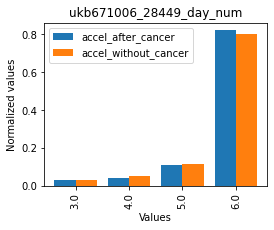


ukb671006_28471_continuous_day
p-value: 8.944167282061107e-06


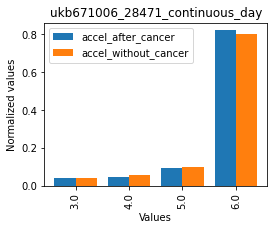


ukb671006_28473_sex
p-value: 6.578298422652438e-14


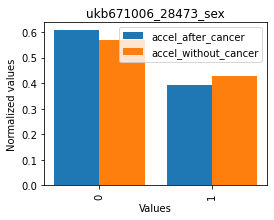


ukb671006_28474_cluster
p-value: 8.864980620204277e-11


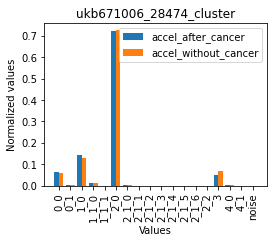


ukb671006_28475_group_eid_old
p-value: 1.5642668208274272e-13


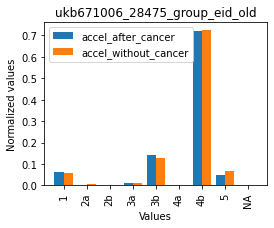


ukb671006_28476_abnormal_group_eid_old
p-value: 1.0266787336518013e-05


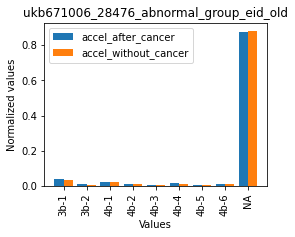


ukb671006_28480_group_five
p-value: 1.2717799856361914e-14


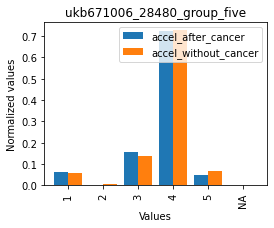

In [23]:
list_statistics = compare_categorical(pheno_list_categorical,
                    df_accel_after_cancer, df_accel_without_cancer, 
                    "accel_after_cancer", "accel_without_cancer",
                                     DIR_OUT, "after_without")

ukb671006_28450_ST_long_mean
p-value: 0.31453884184496494


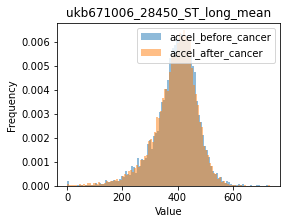

ukb671006_28451_ST_long_sd
p-value: 0.0017694901476367232


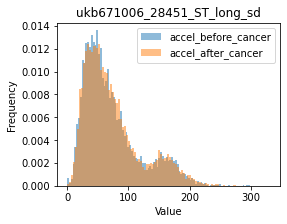

ukb671006_28452_WT_long_mean
p-value: 0.03236472389588954


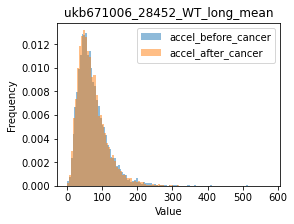

ukb671006_28453_WT_long_sd
p-value: 0.6566504998172309


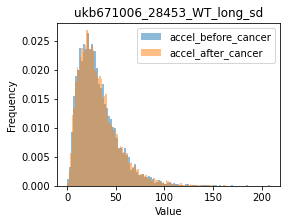

ukb671006_28454_ST_short_mean
p-value: 0.011742488540172914


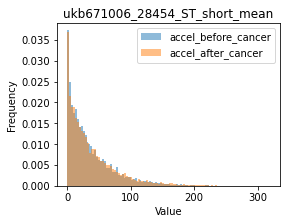

ukb671006_28455_ST_short_sd
p-value: 0.023075209060470007


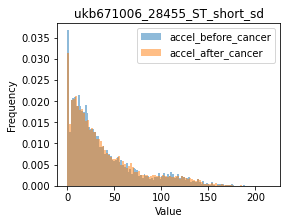

ukb671006_28456_WT_short_mean
p-value: 0.056259665318892184


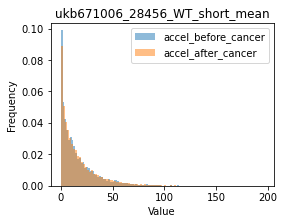

ukb671006_28457_WT_short_sd
p-value: 0.13742699382940365


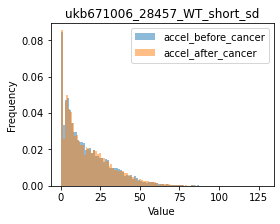

ukb671006_28458_long_window_len_mean
p-value: 0.2220639632335497


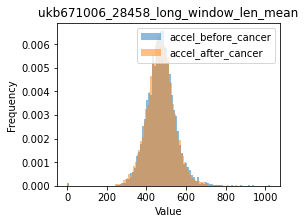

ukb671006_28459_long_window_len_sd
p-value: 0.13160414422877614


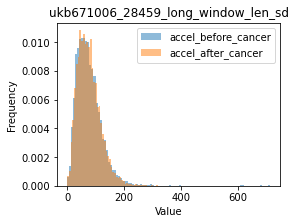

ukb671006_28460_long_window_num_mean
p-value: 0.07330188396861942


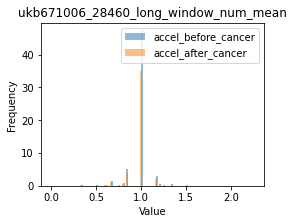

ukb671006_28461_long_window_num_sd
p-value: 0.29610373836024384


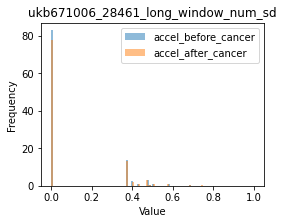

ukb671006_28462_short_window_len_mean
p-value: 0.1954883072310536


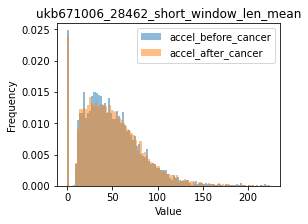

ukb671006_28463_short_window_len_sd
p-value: 0.2847084620915027


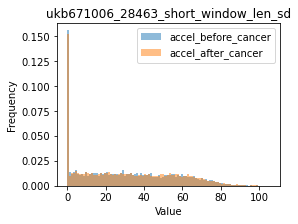

ukb671006_28464_short_window_num_mean
p-value: 0.010116441138508476


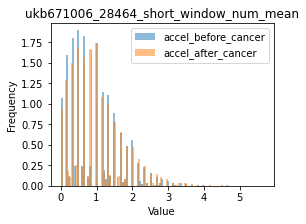

ukb671006_28465_short_window_num_sd
p-value: 0.009230278077219494


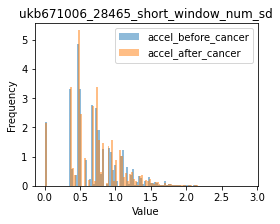

ukb671006_28466_phase_mean
p-value: 0.008134580913492801


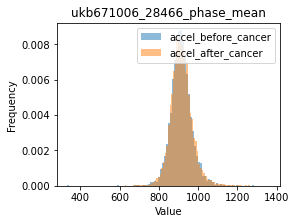

ukb671006_28467_phase_sd
p-value: 0.1793772384144181


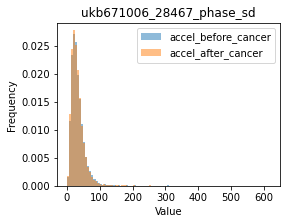

ukb671006_28468_max_period
p-value: 0.7825005611723586


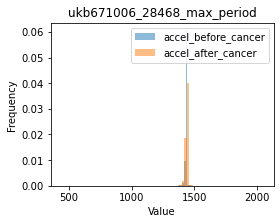

ukb671006_28469_amplitude
p-value: 0.22208030436321669


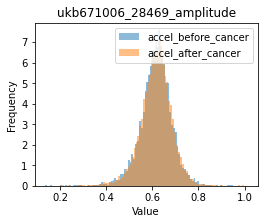

ukb671006_28470_sleep_percentage
p-value: 0.5541497808145797


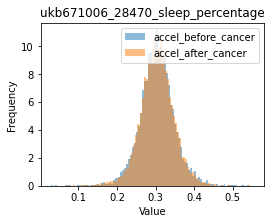

ukb671006_28472_age
p-value: 0.08822533615099137


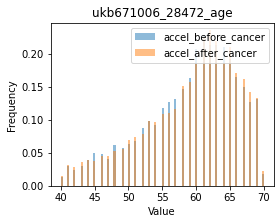

ukb671006_24430_90010-0.0_days
p-value: 2.9940439834922972e-21


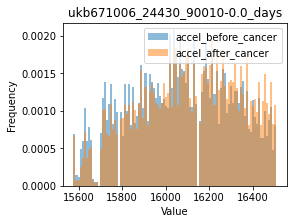

earliest_cancer_days
p-value: 0.0


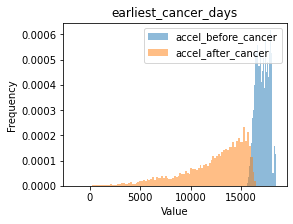

In [24]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_before_cancer, df_accel_after_cancer, 
                    "accel_before_cancer", "accel_after_cancer",
                                     DIR_OUT, "before_after")

ukb671006_28450_ST_long_mean
p-value: 6.835027382186696e-06


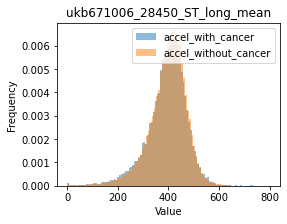

ukb671006_28451_ST_long_sd
p-value: 0.00015397919757126588


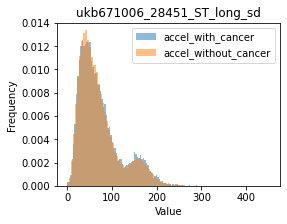

ukb671006_28452_WT_long_mean
p-value: 3.1690857136798926e-33


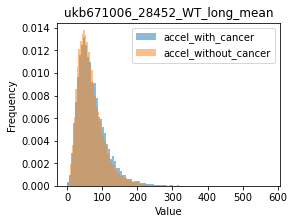

ukb671006_28453_WT_long_sd
p-value: 1.2856943656796778e-17


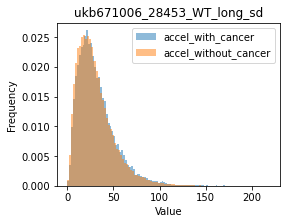

ukb671006_28454_ST_short_mean
p-value: 1.1955229708389527e-41


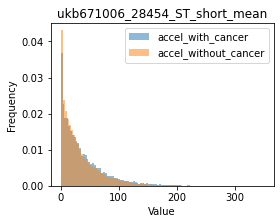

ukb671006_28455_ST_short_sd
p-value: 2.569333694209992e-23


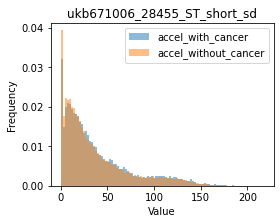

ukb671006_28456_WT_short_mean
p-value: 6.8190519256942586e-40


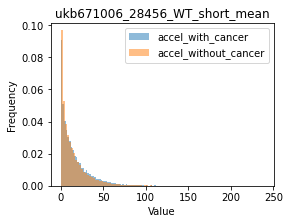

ukb671006_28457_WT_short_sd
p-value: 1.7572211110589495e-24


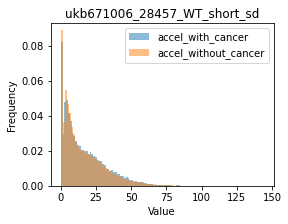

ukb671006_28458_long_window_len_mean
p-value: 0.0015525106448492257


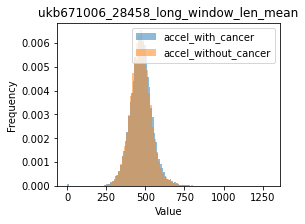

ukb671006_28459_long_window_len_sd
p-value: 9.63464738442461e-05


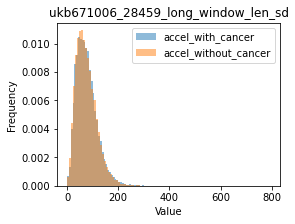

ukb671006_28460_long_window_num_mean
p-value: 0.06596082798087897


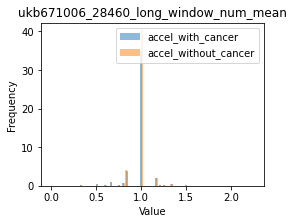

ukb671006_28461_long_window_num_sd
p-value: 1.0827491791161536e-07


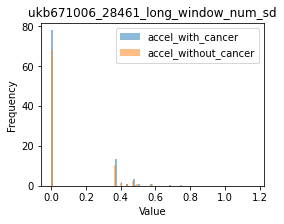

ukb671006_28462_short_window_len_mean
p-value: 1.4960166344274174e-10


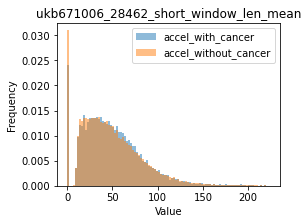

ukb671006_28463_short_window_len_sd
p-value: 3.6315780867993385e-23


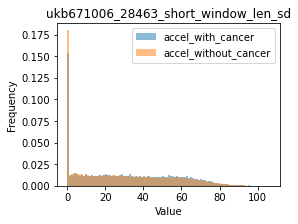

ukb671006_28464_short_window_num_mean
p-value: 2.476106675202694e-58


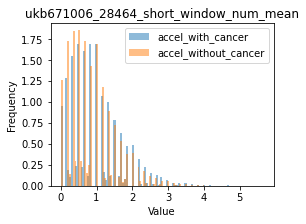

ukb671006_28465_short_window_num_sd
p-value: 4.2726130143084883e-20


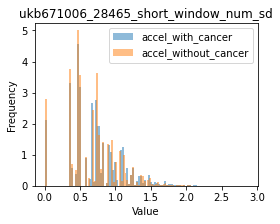

ukb671006_28466_phase_mean
p-value: 3.250196750617663e-05


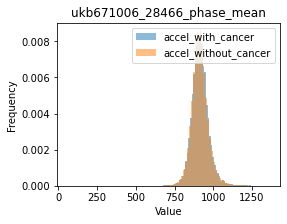

ukb671006_28467_phase_sd
p-value: 1.154486281185571e-33


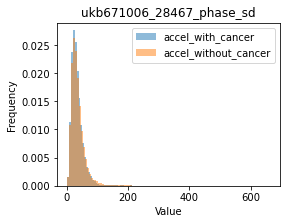

ukb671006_28468_max_period
p-value: 1.1913773108345965e-05


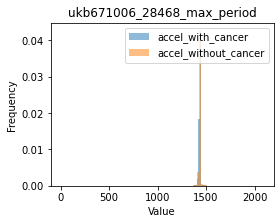

ukb671006_28469_amplitude
p-value: 0.329539982144298


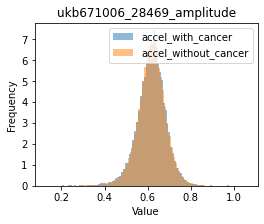

ukb671006_28470_sleep_percentage
p-value: 0.05082920425631424


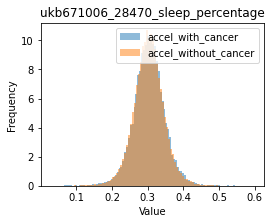

ukb671006_28472_age
p-value: 0.0


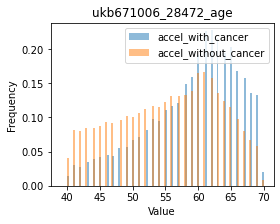

ukb671006_24430_90010-0.0_days
p-value: 0.6821889106504504


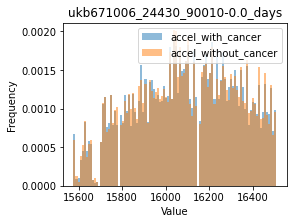

earliest_cancer_days
Skip because the matching data does not exist in both datasets


In [25]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_with_cancer, df_accel_without_cancer, 
                    "accel_with_cancer", "accel_without_cancer",
                                     DIR_OUT, "with_without")

ukb671006_28450_ST_long_mean
p-value: 0.03776036633279769


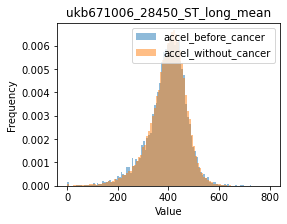

ukb671006_28451_ST_long_sd
p-value: 0.9424035812361999


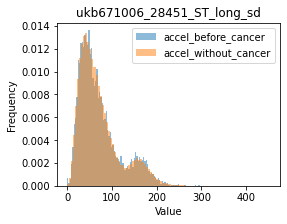

ukb671006_28452_WT_long_mean
p-value: 2.5956820581914352e-20


In [ ]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_before_cancer, df_accel_without_cancer, 
                    "accel_before_cancer", "accel_without_cancer",
                                     DIR_OUT, "before_without")

In [ ]:
list_statistics = compare_continuous(pheno_list_continuous,
                    df_accel_after_cancer, df_accel_without_cancer, 
                    "accel_after_cancer", "accel_without_cancer",
                                     DIR_OUT, "after_without")

### Merge the results

In [19]:
# Create an empty DataFrame to store the concatenated CSV data
df_all = pl.DataFrame()
i_iter = 0
cols_drop = ['MannWhitneyU-stat', 'chi-sq', 'data1' , 'data2']

# Loop through the subfolders of DIR_OUT
for subdir, _, files in os.walk(DIR_OUT):
    # Loop through the files in each subfolder
    print("Scanning subdirectory", subdir)

    df_concat = pl.DataFrame()
    for file in files:
        # Check if the file name matches the pattern
        if file.startswith('compare_') and file.endswith('.csv'):
            # Read the CSV file and append its data to the DataFrame
            file_path = os.path.join(subdir, file)
            df_temp = pl.read_csv(file_path)
            for column in cols_drop:
                try:
                    df_temp = df_temp.drop(column)
                except:
                    pass
            df_concat = pl.concat([df_concat, df_temp])
    if df_concat.shape[0] == 0: # If no data is available, then pass
        continue
        
    df_concat = (df_concat
                 .with_columns(pl.col("p-value")
                            .alias(df_concat['suffix'].to_numpy()[0])
                           )
                 .drop(["p-value", "suffix"])
              )
    
    if i_iter == 0:
        df_all = df_concat.clone()
        i_iter = 1
    else:
        # Perform outer join on the concatenated DataFrame
        df_all = df_all.join(df_concat, on="phenotype", how='outer')

        
# Export the result
file_out = os.path.join(DIR_OUT, "p-values.csv")
df_all.write_csv(file_out)

# Print the result
print(df_all)

Scanning subdirectory analysis\specific\analysis_20230424_01_ACCEL_cancer
Scanning subdirectory analysis\specific\analysis_20230424_01_ACCEL_cancer\before_without
Scanning subdirectory analysis\specific\analysis_20230424_01_ACCEL_cancer\with_without
Scanning subdirectory analysis\specific\analysis_20230424_01_ACCEL_cancer\after_without
Scanning subdirectory analysis\specific\analysis_20230424_01_ACCEL_cancer\before_after
shape: (31, 5)
┌───────────────────────────────────┬────────────────┬──────────────┬───────────────┬──────────────┐
│ phenotype                         ┆ before_without ┆ with_without ┆ after_without ┆ before_after │
│ ---                               ┆ ---            ┆ ---          ┆ ---           ┆ ---          │
│ str                               ┆ f64            ┆ f64          ┆ f64           ┆ f64          │
╞═══════════════════════════════════╪════════════════╪══════════════╪═══════════════╪══════════════╡
│ ukb671006_28450_ST_long_mean      ┆ 0.03776        ┆ 

## Enlarge

In [464]:
def plot_continuous_enlarge(df1, df2, pheno, list_range):
    # Calculate mean, median, and standard deviation for the two dataframes
    try:
        np_before = pl_to_float(df1[pheno])
        np_after = pl_to_float(df2[pheno])
        np_before = np_before[~np.isnan(np_before)]
        np_after = np_after[~np.isnan(np_after)]
    except:
        print("Skip because the matching data does not exist in both datasets")
        exit

    if len(np_before) < 10:
        print("Skip because the matching data does not exist in both datasets")
        exit
    if len(np_after) < 10:
        print("Skip because the matching data does not exist in both datasets")
        exit

    mean_before = np_before.mean()
    median_before = np.median(np_before)
    std_before = np_before.std()

    mean_after = np_after.mean()
    median_after = np.median(np_after)
    std_after = np_after.std()

    # Plot the distribution of the pheno column for each dataframe
    plt.figure(figsize=[4, 3])
    plt.xlim(list_range[0], list_range[1]) 
    plt.hist(np_before, alpha=0.5, label="accel before cancer", density=True, bins=100)
    plt.hist(np_after, alpha=0.5, label="accel without cancer", density=True, bins=100)
    plt.legend(loc="upper right")
    plt.title(pheno)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

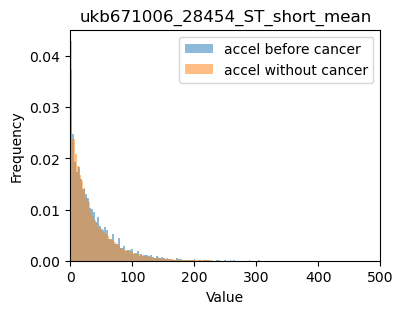

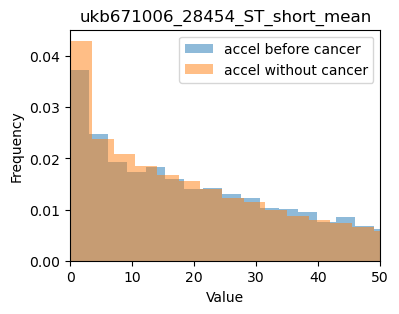

In [466]:
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, "ukb671006_28454_ST_short_mean", [0,500])
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, "ukb671006_28454_ST_short_mean", [0,50])

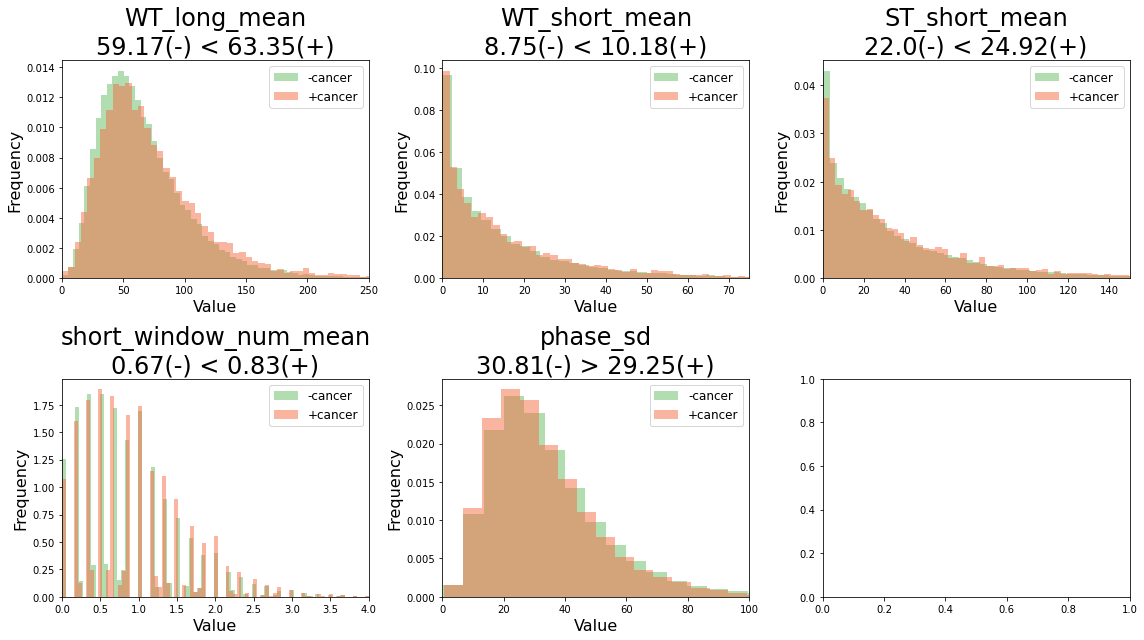

In [21]:
def round_prec(n, prec): # Round a number to precision up to "prec" digits
    result = n * 1.0
    n_digit = int(np.log10(result))
    result = result / (10 ** n_digit)
    result = np.round(result, prec)
    return result * (10 ** n_digit)

def plot_continuous_enlarge(df1, df2, plot_list):
    fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=[16, 9])
    for i, (pheno, suffix, list_range) in enumerate(plot_list, 1):
        plot_x = int((i-1) / 3) + 1
        plot_y = i % 3

        # Calculate mean, median, and standard deviation for the two dataframes
        try:
            np_before = pl_to_float(df1[pheno])
            np_after = pl_to_float(df2[pheno])
            np_before = np_before[~np.isnan(np_before)]
            np_after = np_after[~np.isnan(np_after)]
        except:
            print("Skip because the matching data does not exist in both datasets")
            exit

        if len(np_before) < 10:
            print("Skip because the matching data does not exist in both datasets")
            exit
        if len(np_after) < 10:
            print("Skip because the matching data does not exist in both datasets")
            exit

        median_before = np.median(np_before)
        median_after = np.median(np_after)
           
        median_before = np.round(median_before, 2)
        median_after = np.round(median_after, 2)
        
        if median_before < median_after:
            sign = ">"
        else:
            sign = "<"

        # Plot the distribution of the pheno column for each dataframe
        sub_plot = axes[plot_x-1, plot_y-1]
        sub_plot.set_xlim(list_range[0], list_range[1]) 
        sub_plot.hist(np_after, alpha=0.5, label="-cancer", density=True, bins=100, color='#66bd63')
        sub_plot.hist(np_before, alpha=0.5, label="+cancer", density=True, bins=100, color='#f46d43')
        sub_plot.legend(loc="upper right", fontsize=12)
        sub_plot.set_title(suffix + "\n" + \
                           str(median_after) + "(-) " + sign + " " + str(median_before) + "(+)",
                          fontsize=24)
        sub_plot.set_xlabel("Value", fontsize=16)
        sub_plot.set_ylabel("Frequency", fontsize=16)
    plt.show()
    

plot_list = [
["ukb671006_28452_WT_long_mean", "WT_long_mean", [0, 250]],
["ukb671006_28456_WT_short_mean", "WT_short_mean", [0, 75]],
["ukb671006_28454_ST_short_mean", "ST_short_mean", [0, 150]],
["ukb671006_28464_short_window_num_mean", "short_window_num_mean", [0, 4]],
["ukb671006_28467_phase_sd", "phase_sd", [0,100]],
]
    
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, plot_list)

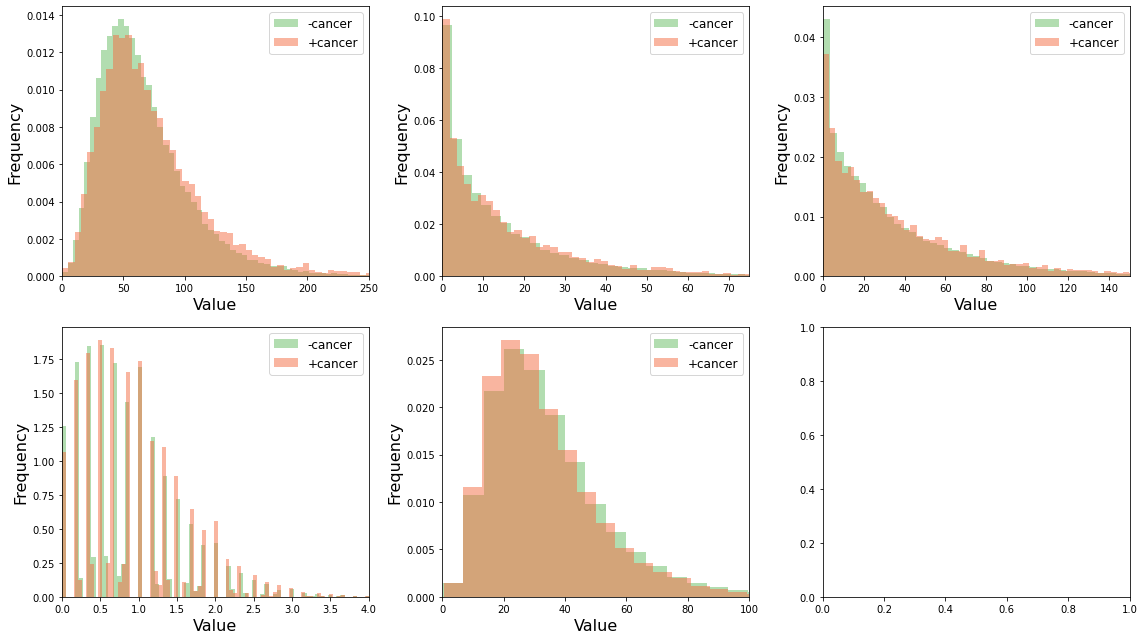

In [20]:
def round_prec(n, prec): # Round a number to precision up to "prec" digits
    result = n * 1.0
    n_digit = int(np.log10(result))
    result = result / (10 ** n_digit)
    result = np.round(result, prec)
    return result * (10 ** n_digit)

def plot_continuous_enlarge(df1, df2, plot_list):
    fig, axes = plt.subplots(2, 3, tight_layout=True, figsize=[16, 9])
    for i, (pheno, suffix, list_range) in enumerate(plot_list, 1):
        plot_x = int((i-1) / 3) + 1
        plot_y = i % 3

        # Calculate mean, median, and standard deviation for the two dataframes
        try:
            np_before = pl_to_float(df1[pheno])
            np_after = pl_to_float(df2[pheno])
            np_before = np_before[~np.isnan(np_before)]
            np_after = np_after[~np.isnan(np_after)]
        except:
            print("Skip because the matching data does not exist in both datasets")
            exit

        if len(np_before) < 10:
            print("Skip because the matching data does not exist in both datasets")
            exit
        if len(np_after) < 10:
            print("Skip because the matching data does not exist in both datasets")
            exit

        median_before = np.median(np_before)
        median_after = np.median(np_after)
           
        median_before = np.round(median_before, 2)
        median_after = np.round(median_after, 2)
        
        if median_before < median_after:
            sign = ">"
        else:
            sign = "<"

        # Plot the distribution of the pheno column for each dataframe
        sub_plot = axes[plot_x-1, plot_y-1]
        sub_plot.set_xlim(list_range[0], list_range[1]) 
        sub_plot.hist(np_after, alpha=0.5, label="-cancer", density=True, bins=100, color='#66bd63')
        sub_plot.hist(np_before, alpha=0.5, label="+cancer", density=True, bins=100, color='#f46d43')
        sub_plot.legend(loc="upper right", fontsize=12)
#         sub_plot.set_title(suffix + "\n" + \
#                            str(median_after) + "(-) " + sign + " " + str(median_before) + "(+)",
#                           fontsize=24)
        sub_plot.set_xlabel("Value", fontsize=16)
        sub_plot.set_ylabel("Frequency", fontsize=16)
    plt.show()
    

plot_list = [
["ukb671006_28452_WT_long_mean", "WT_long_mean", [0, 250]],
["ukb671006_28456_WT_short_mean", "WT_short_mean", [0, 75]],
["ukb671006_28454_ST_short_mean", "ST_short_mean", [0, 150]],
["ukb671006_28464_short_window_num_mean", "short_window_num_mean", [0, 4]],
["ukb671006_28467_phase_sd", "phase_sd", [0,100]],
]
    
plot_continuous_enlarge(df_accel_before_cancer, df_accel_without_cancer, plot_list)

## Correlation between top variables?
Especially with:
- Age
- Sex

In [22]:
list_top_phenotypes = ["ukb671006_28452_WT_long_mean", 
"ukb671006_28456_WT_short_mean", 
"ukb671006_28454_ST_short_mean", 
"ukb671006_28464_short_window_num_mean",
"ukb671006_28467_phase_sd"]

# With age
print("With age")
for pheno in list_top_phenotypes:
    r, pval = stats.pearsonr(df_accel_before_cancer["ukb671006_28472_age"].cast(pl.Float32), 
                             df_accel_before_cancer[pheno].cast(pl.Float32))
    print("Phenotype:", pheno, "r, p-value =", r, pval)


print()

# With sex
print("With sex")
for pheno in list_top_phenotypes:
    r, pval = stats.pearsonr(df_accel_before_cancer["ukb671006_28473_sex"].cast(pl.Float32), 
                             df_accel_before_cancer[pheno].cast(pl.Float32))
    print("Phenotype:", pheno, "r, p-value =", r, pval)

With age
Phenotype: ukb671006_28452_WT_long_mean r, p-value = 0.10709251514704159 5.062645236865369e-17
Phenotype: ukb671006_28456_WT_short_mean r, p-value = 0.12638272364042769 3.8847149920239744e-23
Phenotype: ukb671006_28454_ST_short_mean r, p-value = 0.15557703232233921 2.402560071562606e-34
Phenotype: ukb671006_28464_short_window_num_mean r, p-value = 0.17722211770759888 3.285084398344547e-44
Phenotype: ukb671006_28467_phase_sd r, p-value = -0.14210770155458555 7.040316534324658e-29

With sex
Phenotype: ukb671006_28452_WT_long_mean r, p-value = 0.15948262693004264 5.0089321682485086e-36
Phenotype: ukb671006_28456_WT_short_mean r, p-value = 0.09894884923605396 9.610100462684633e-15
Phenotype: ukb671006_28454_ST_short_mean r, p-value = -0.0014304906791633024 0.9110741775339937
Phenotype: ukb671006_28464_short_window_num_mean r, p-value = 0.09020978536158014 1.6964361882183514e-12
Phenotype: ukb671006_28467_phase_sd r, p-value = 0.023802359084088946 0.06308369537869532


# Comparison per sub-divisions
Compare:
- Groups:
  - accel before cancer
  - accel without cancer
- Among:
  - Clusters
  - Sleep indexes

In [423]:
mm("""
graph LR;
    classDef class1 fill:#FFFFFF,stroke:#CCCCCC,color:#BBBBBB
    
    cancer_before[cancer before accel]:::class1 -.-> ACCEL[ACCEL cluster 1];
    ACCEL --> cancer_after[cancer after accel];
    ACCEL --> nocancer[no cancer record]
""")

mm("""
graph LR;
    classDef class1 fill:#FFFFFF,stroke:#CCCCCC,color:#BBBBBB
    
    cancer_before[cancer before accel]:::class1 -.-> ACCEL[ACCEL cluster 2];
    ACCEL --> cancer_after[cancer after accel];
    ACCEL --> nocancer[no cancer record]
""")

mm("""
graph LR;
    classDef class1 fill:#FFFFFF,stroke:#CCCCCC,color:#BBBBBB
    
    cancer_before[cancer before accel]:::class1 -.-> ACCEL[ACCEL cluster 3];
    ACCEL --> cancer_after[cancer after accel];
    ACCEL --> nocancer[no cancer record]
""")

print()
print()
print()
print()

mm("""
graph LR;
    classDef class_big font-size:15px,font-weight:bold
    classDef class_small font-size:12px
    
    ACCEL1[ACCEL cluster X] --> cancer_after1[cancer record]:::class_big;
    ACCEL1 --> nocancer1[no cancer record]:::class_small;

    ACCEL2[ACCEL cluster Y] --> cancer_after2[cancer record]:::class_small;
    ACCEL2 --> nocancer2[no cancer record]:::class_big;
""")

print()
print()
print()
print()

mm("""
graph LR;
    classDef class_big font-size:15px,font-weight:bold
    classDef class_small font-size:12px
    
    ACCEL1[ACCEL index A is high] --> cancer_after1[cancer record]:::class_big;
    ACCEL1 --> nocancer1[no cancer record]:::class_small;

    ACCEL2[ACCEL index A is low] --> cancer_after2[cancer record]:::class_small;
    ACCEL2 --> nocancer2[no cancer record]:::class_big;
""")

print()
print()
print()
print()


pheno, p-value: ukb671006_28449_day_num 0.00036335259406626883


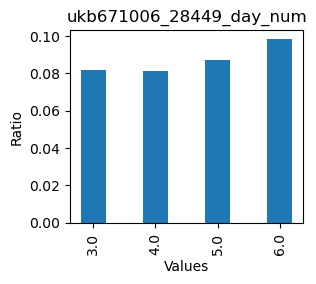

pheno, p-value: ukb671006_28471_continuous_day 0.00019961636037819065


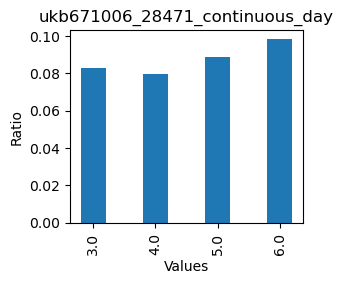

pheno, p-value: ukb671006_28473_sex 6.988449211101014e-42


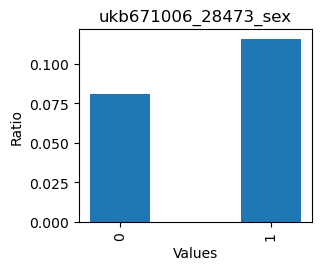

pheno, p-value: ukb671006_28474_cluster 0.0003978387340715889


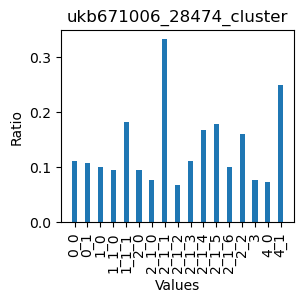

pheno, p-value: ukb671006_28475_group_eid_old 1.1286388887091419e-05


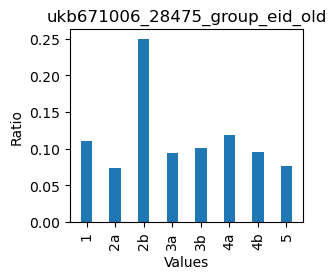

pheno, p-value: ukb671006_28476_abnormal_group_eid_old 0.0004029354025918467


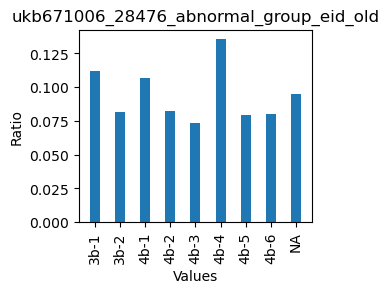

pheno, p-value: ukb671006_28480_group_five 3.357571472246521e-05


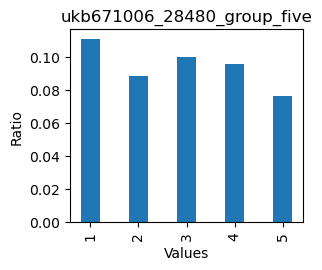

In [396]:
for pheno in pheno_list_categorical:
    #print(pheno)
    
    # List up the frequency of each value
    freq1 = df_accel_before_cancer[pheno].value_counts().rename({"counts": "with_cancer"})
    freq2 = df_accel_without_cancer[pheno].value_counts().rename({"counts": "without_cancer"})

    # Create a contingency table of the frequencies
    cont_table = (freq1.join(freq2, on=pheno, how='outer')
                  .with_column((pl.col("with_cancer") / pl.col("without_cancer")).alias("ratio")
                              )
                  .sort(by=pheno)
                  .drop_nulls()
                 )
    
    # Perform the chi-squared test of independence
    chi2, p_value, dof, expected = stats.chi2_contingency(cont_table[["with_cancer", "without_cancer"]])

    # Print the results of the test
    print("pheno, p-value:", pheno, p_value)

    cont_table = cont_table.drop(["with_cancer", "without_cancer"])
        
    # Create a bar chart of the normalized data
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 2.5)
    plt.title(pheno)
    ax.bar(np.arange(cont_table.shape[0]), cont_table["ratio"], width=0.4)
    ax.set_xticks(np.arange(cont_table.shape[0]))
    ax.set_xticklabels(cont_table[pheno], rotation='vertical')
    ax.set_xlabel("Values")
    ax.set_ylabel("Ratio")
    plt.show()

## See what's inside Cluster 2b

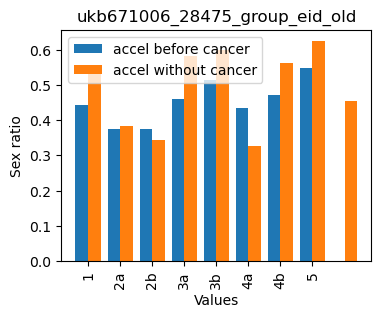

In [405]:
# pheno = "ukb671006_28475_group_eid_old"

# set_label = set(df_accel_before_cancer[pheno]) | set(df_accel_without_cancer[pheno])

def func_ratio_sex(df, pheno_sex, pheno2):
   # Returns a Polars.DataFrame of
    # sex ratio among different pheno2
    # (pheno_sex denotes the name of sex phenotype)
    sex_1 = (df
             .groupby(pl.col([pheno_sex, pheno2]))
             .count()
             .sort(by=[pheno_sex, pheno2])
            )

    sex_ratio_0 = sex_1.filter(pl.col(pheno_sex) == "0")
    sex_ratio_1 = sex_1.filter(pl.col(pheno_sex) == "1")

    cont_table = (sex_ratio_0
                  .with_columns(sex_ratio_1["count"]
                                .alias("count1"))
                 )
    
    ratio_table = (cont_table
                   .with_columns((pl.col("count") / (pl.col("count") + pl.col("count1")))
                                 .alias("ratio"))
                   .drop([pheno_sex, "count", "count1"])
                  )
    return cont_table, ratio_table

cont_table_before_cancer, sex_ratio_before_cancer = func_ratio_sex(df_accel_before_cancer, 
               "ukb671006_28473_sex", "ukb671006_28475_group_eid_old")
cont_table_without_cancer, sex_ratio_without_cancer = func_ratio_sex(df_accel_without_cancer, 
               "ukb671006_28473_sex", "ukb671006_28475_group_eid_old")


ticks = sex_ratio_before_cancer["ukb671006_28475_group_eid_old"]

# Create a bar chart of the normalized data
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
plt.title("ukb671006_28475_group_eid_old")

ax.bar(np.arange(sex_ratio_before_cancer.shape[0]) - 0.2,
       sex_ratio_before_cancer[:, 1], width=0.4, label="accel before cancer")

ax.bar(np.arange(sex_ratio_without_cancer.shape[0]) + 0.2,
       sex_ratio_without_cancer[:, 1], width=0.4, label="accel without cancer")

ax.set_xticks(np.arange(sex_ratio_before_cancer.shape[0]))
ax.set_xticklabels(ticks, rotation='vertical')
ax.set_xlabel("Values")
ax.set_ylabel("Sex ratio")
ax.legend()

plt.show()

print()

In [406]:
cont_table_before_cancer

ukb671006_28473_sex,ukb671006_28475_group_eid_old,count,count1
str,str,u32,u32
"""0""","""1""",186,233
"""0""","""2a""",9,15
"""0""","""2b""",3,5
"""0""","""3a""",30,35
"""0""","""3b""",425,399
"""0""","""4a""",10,13
"""0""","""4b""",2085,2323
"""0""","""5""",179,148


# Propensity score-based analyses
https://www.dskomei.com/entry/2020/05/18/234407

## Adjusted Treatment Effect (ATE) calculation
See that propensity scores are biased among subgroupes!

In [5]:
df_comparison = pl.concat([
    df_accel_before_cancer.with_columns(pl.Series([1] * len(df_accel_before_cancer)).alias("cancer")),
    df_accel_without_cancer.with_columns(pl.Series([0] * len(df_accel_without_cancer)).alias("cancer"))
])
df_comparison

shape: (69812, 40)
┌─────────┬───────────────┬───────────────┬───────────────┬─────┬───────────────┬──────────────┬──────────────┬────────┐
│ eid     ┆ ukb671006_244 ┆ ukb671006_284 ┆ ukb671006_284 ┆ ... ┆ accel_after_c ┆ ukb671006_24 ┆ earliest_can ┆ cancer │
│ ---     ┆ 30_90010-0.0  ┆ 48_eid_old    ┆ 49_day_num    ┆     ┆ ancer         ┆ 430_90010-0. ┆ cer_days     ┆ ---    │
│ i64     ┆ ---           ┆ ---           ┆ ---           ┆     ┆ ---           ┆ 0_days       ┆ ---          ┆ i64    │
│         ┆ str           ┆ str           ┆ str           ┆     ┆ bool          ┆ ---          ┆ i64          ┆        │
│         ┆               ┆               ┆               ┆     ┆               ┆ i64          ┆              ┆        │
╞═════════╪═══════════════╪═══════════════╪═══════════════╪═════╪═══════════════╪══════════════╪══════════════╪════════╡
│ 1000337 ┆ 2014-11-15    ┆ 5579755       ┆ 6.0           ┆ ... ┆ false         ┆ 16107        ┆ 16613        ┆ 1      │
│ 1002455 ┆ 2013-07-20    ┆ 4988731       ┆ 6.0           ┆ ... ┆ false         ┆ 15624        ┆ 17654        ┆ 1      │
│ 1002651 ┆ 2013-07-20    ┆ 2962276       ┆ 6.0           ┆ ... ┆ false         ┆ 15624        ┆ 15956        ┆ 1      │
│ 1002720 ┆ 2014-11-15    ┆ 2112328       ┆ 6.0           ┆ ... ┆ false         ┆ 16107        ┆ 17458        ┆ 1      │
│ ...     ┆ ...           ┆ ...           ┆ ...           ┆ ... ┆ ...           ┆ ...          ┆ ...          ┆ ...    │
│ 6024605 ┆ 2013-08-02    ┆ 1910696       ┆ 6.0           ┆ ... ┆ null          ┆ 15637        ┆ null         ┆ 0      │
│ 6024698 ┆ 2013-07-22    ┆ 1252952       ┆ 5.0           ┆ ... ┆ null          ┆ 15626        ┆ null         ┆ 0      │
│ 6024737 ┆ 2014-06-09    ┆ 4741522       ┆ 6.0           ┆ ... ┆ null          ┆ 15948        ┆ null         ┆ 0      │
│ 6024818 ┆ 2014-11-15    ┆ 6016103       ┆ 3.0           ┆ ... ┆ null          ┆ 16107        ┆ null         ┆ 0      │
└─────────┴───────────────┴───────────────┴───────────────┴─────┴───────────────┴──────────────┴──────────────┴────────┘

limit_output extension: Maximum message size of 5000 exceeded with 30700 characters

In [108]:
# https://zenn.dev/s1ok69oo/articles/c058108acb83e7
def func_propensity_ATE(df, x_names, y_name, z_name, z_subdivision, step=0.1):
    # 傾向スコアを算出するために使用する説明変数
    X = df[x_names].astype(float)
    X = sm.add_constant(X)

    # 処置変数
    if z_subdivision == "": # Continuous variable
        D = df[z_name].astype(float)
        D = (D > np.median(D))
        df["surrogate"] = D
    else: # Categorical variable
        D = (df[z_name] == z_subdivision)

    # 傾向スコアを算出
    with redirect_stdout(StringIO()):
        try:
            with warnings.catch_warnings(record=True) as warning_list:
                model = sm.Logit(D, X)
                result = model.fit()
            warnings_messages = [str(warning.message) for warning in warning_list]
            warnings_messages = "_".join(warnings_messages)
        except Exception as e:
            warnings_messages = e
            return -999999, warnings_messages
    
    df["propensity_score"] = result.predict(X)

    plt.figure(figsize=[4, 3])
    plt.hist([df[D]["propensity_score"],
              df[~D]["propensity_score"],
             ],
             alpha=0.5, label=["True", "False"], density=True, bins=50)
    plt.legend(loc="upper right")
    plt.title(z_name)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()
    
    
    scores = np.arange(0, 1, step)
    match_arr = np.array([])

    for score in scores:
        _df = df[(df["propensity_score"] >= score) & 
                 (df["propensity_score"] < score+step)]
        if z_subdivision == "": # Continuous variable
            tmp0 = np.array(_df[_df["surrogate"] == False]["cancer"])
            tmp1 = np.array(_df[_df["surrogate"] == True]["cancer"])
        else: # Categorical variable
            tmp0 = np.array(_df[_df[z_name] != z_subdivision]["cancer"])
            tmp1 = np.array(_df[_df[z_name] == z_subdivision]["cancer"])
        if (tmp0.size!=0) and (tmp1.size!=0):
            match_arr = np.append(match_arr, tmp1.mean() - tmp0.mean())
    
    if warnings_messages == "":
        warnings_messages = "None"

    return match_arr.mean(), warnings_messages

Phenotype = ukb671006_28474_cluster
subdivision = 3


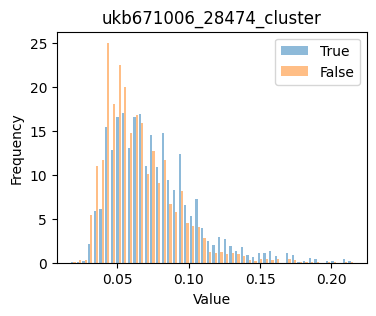

ATE = -0.02051022668478956

subdivision = 4_1


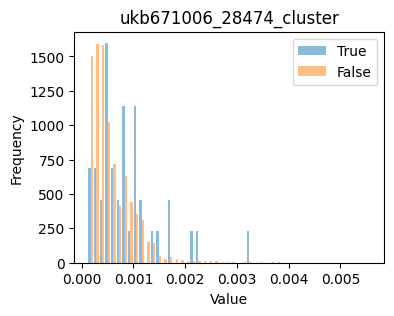

ATE = 0.1127157025740985

subdivision = 2_1_6


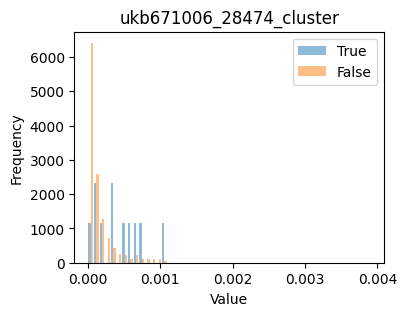

ATE = 0.0035607721170965306

subdivision = noise


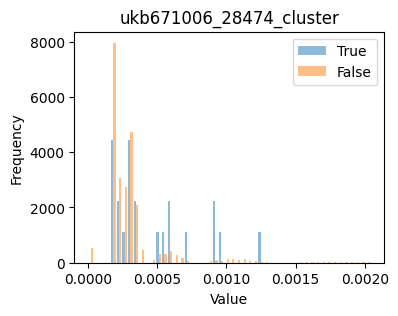

ATE = -0.0873764149591632
Warnings= Maximum Likelihood optimization failed to converge. Check mle_retvals

subdivision = 1_1_0


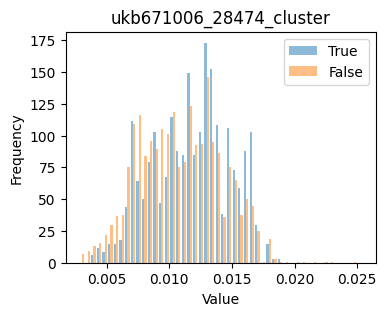

ATE = -0.0012698982614131882

subdivision = 2_2


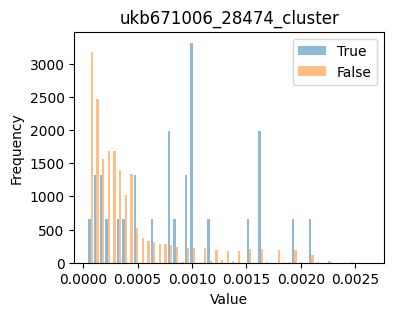

ATE = 0.05060317526203151

subdivision = 2_1_1


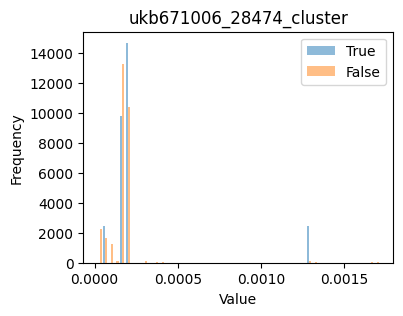

ATE = 0.16267908309455587

subdivision = 2_1_2


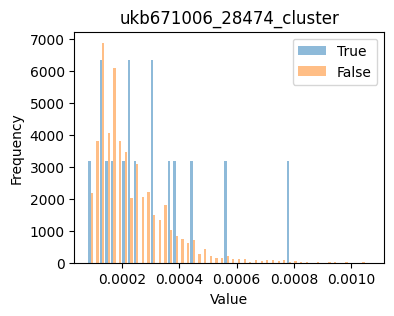

ATE = -0.02485457619347814

subdivision = 0_0


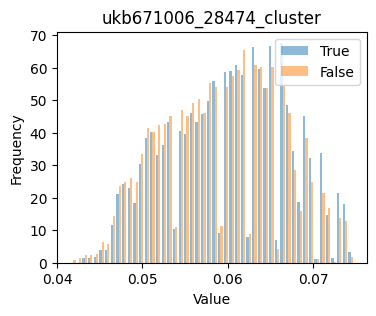

ATE = 0.013472143059606909

subdivision = 2_1_0


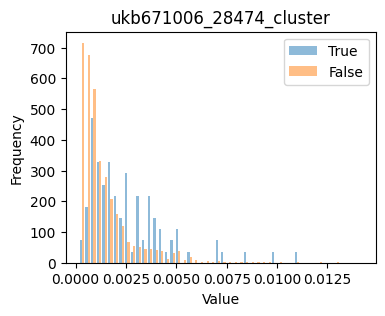

ATE = -0.015942688289706103

subdivision = 1_0


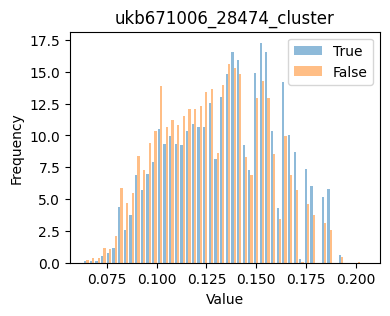

ATE = -0.0014341361604202664

subdivision = 2_1_4


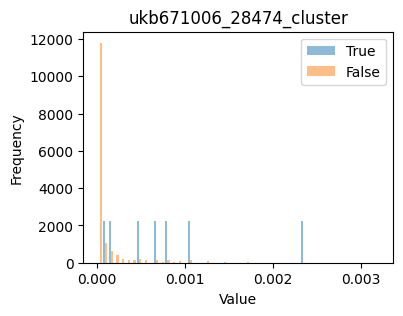

ATE = 0.055513829340919085
Warnings= Maximum Likelihood optimization failed to converge. Check mle_retvals

subdivision = 2_1_3


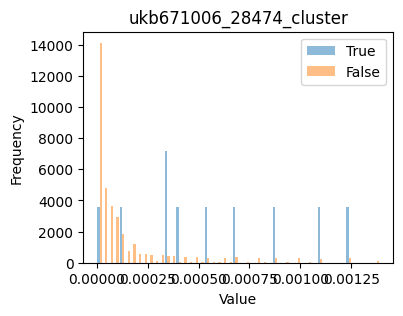

ATE = 0.012652932580728346
Warnings= Maximum Likelihood optimization failed to converge. Check mle_retvals

subdivision = 0_1


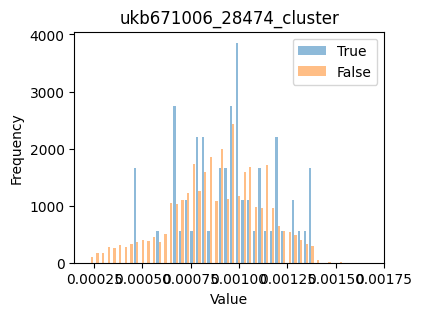

ATE = 0.0094336917562724

subdivision = 4_0


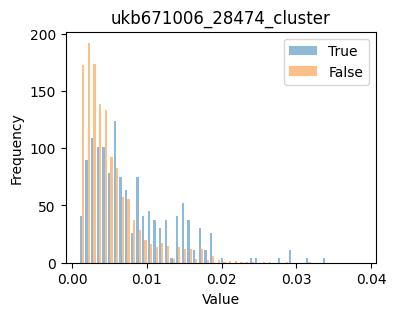

ATE = -0.019458602496746705

subdivision = 2_0


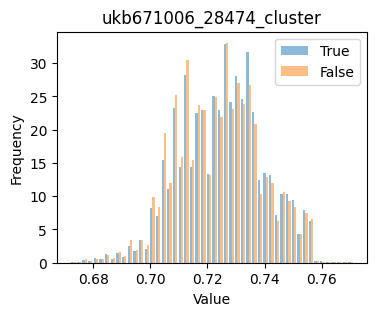

ATE = 0.0004707364547825929

subdivision = 1_1_1


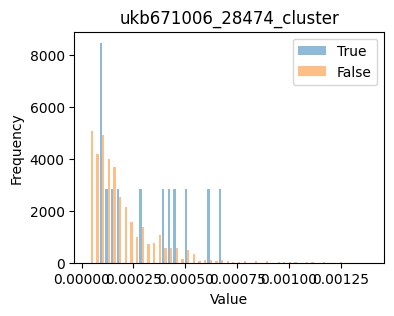

ATE = 0.06650965905396486

subdivision = 2_1_5


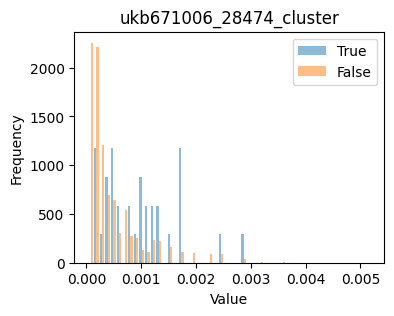

ATE = 0.06419661728565554

Phenotype = ukb671006_28475_group_eid_old
subdivision = 5


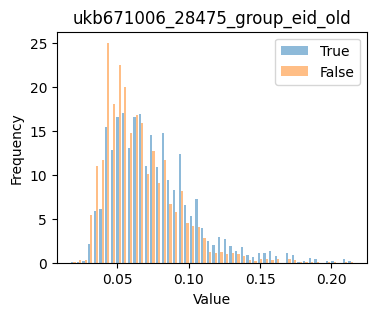

ATE = -0.02051022668478956

subdivision = 1


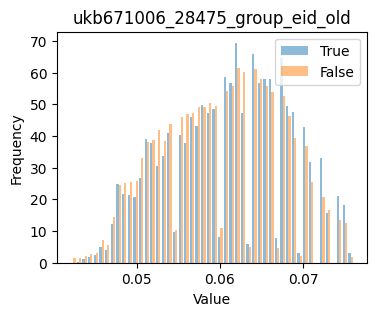

ATE = 0.013433721522655512

subdivision = 2b


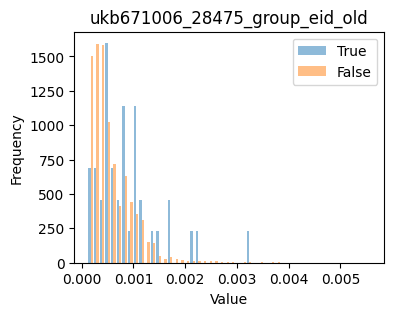

ATE = 0.1127157025740985

subdivision = 3a


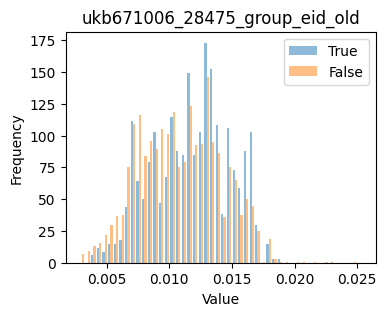

ATE = -0.0012698982614131882

subdivision = 4b


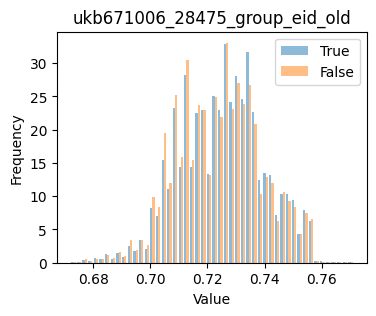

ATE = 0.0004707364547825929

subdivision = 3b


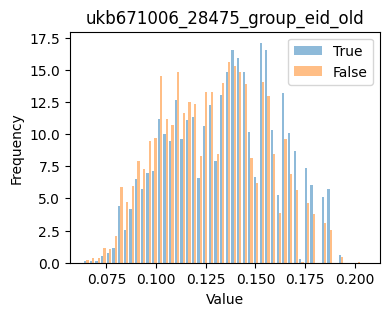

ATE = -0.0011725005408828384

subdivision = NA


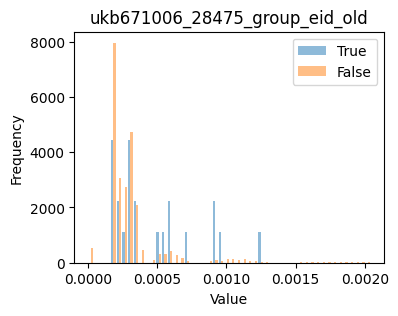

ATE = -0.0873764149591632
Warnings= Maximum Likelihood optimization failed to converge. Check mle_retvals

subdivision = 2a


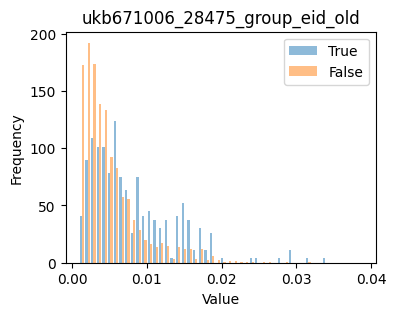

ATE = -0.019458602496746705

subdivision = 4a


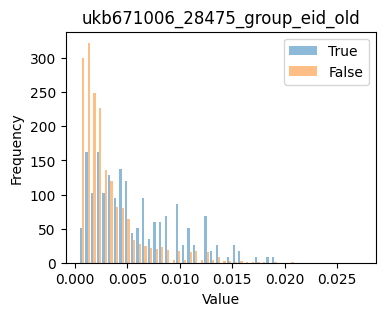

ATE = 0.019191982084964435

Phenotype = ukb671006_28476_abnormal_group_eid_old
subdivision = 4b-2


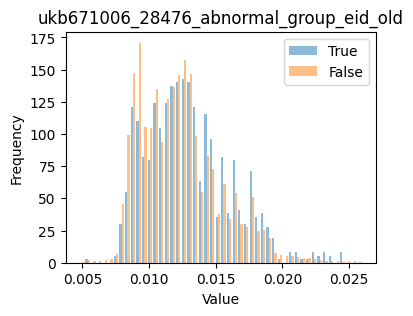

ATE = -0.01164586817692731

subdivision = 4b-5


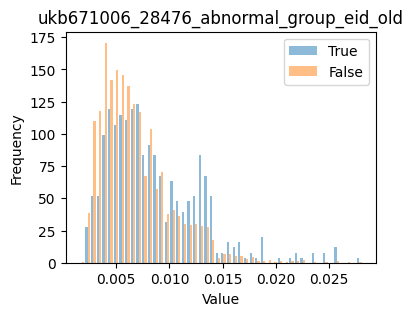

ATE = -0.013601567469959733

subdivision = 4b-1


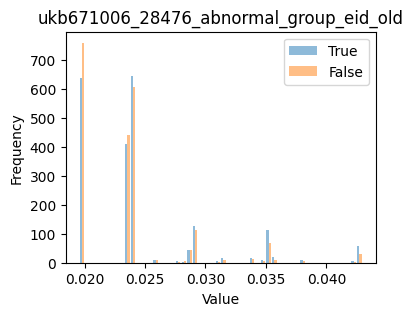

ATE = 0.009054253387290295

subdivision = 3b-1


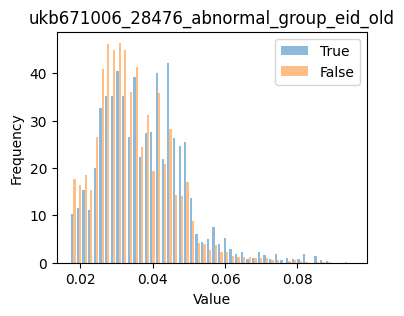

ATE = 0.01353372144054786

subdivision = 4b-4


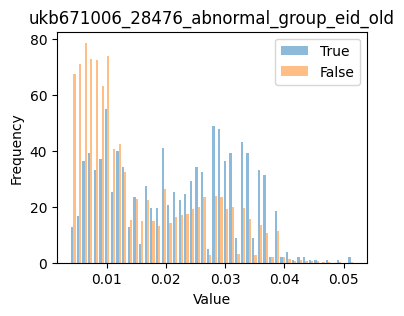

ATE = 0.0326667396615377

subdivision = 3b-2


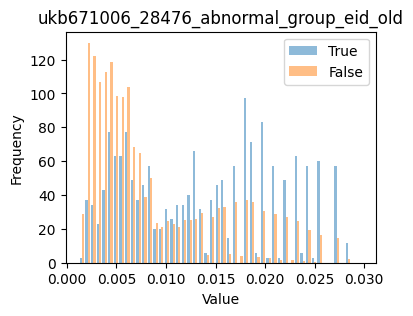

ATE = -0.012168967880775025

subdivision = 4b-6


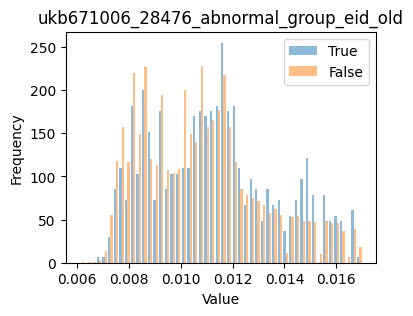

ATE = -0.01332075518381158

subdivision = NA


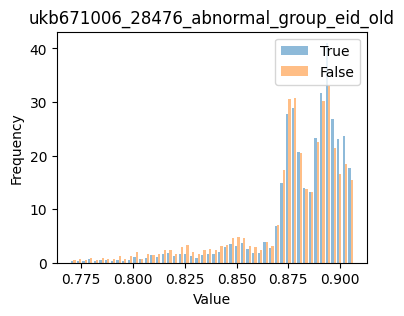

ATE = 0.013669644425694204

subdivision = 4b-3


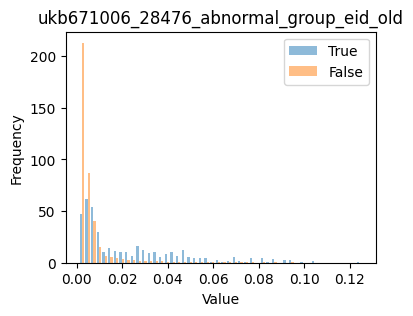

ATE = -0.01359704985832996

Phenotype = ukb671006_28480_group_five
subdivision = 3


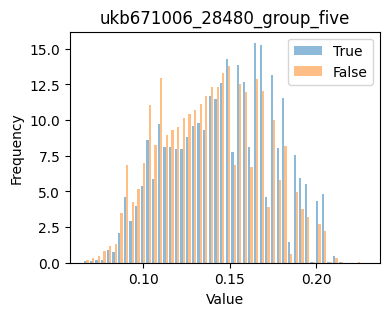

ATE = -0.00372645258535158

subdivision = 5


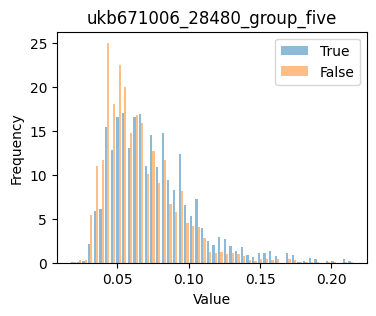

ATE = -0.02051022668478956

subdivision = 1


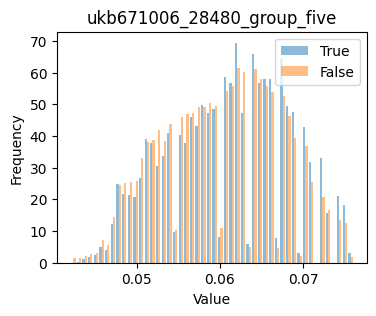

ATE = 0.013433721522655512

subdivision = 4


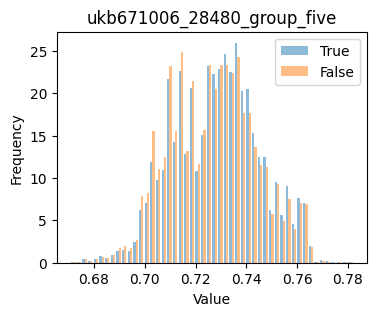

ATE = 0.002128530334763429

subdivision = 2


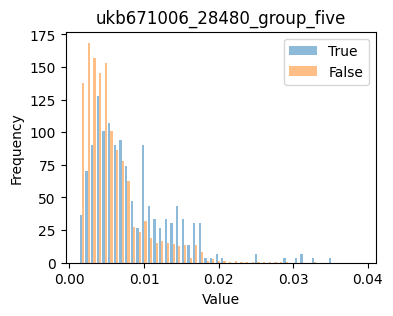

ATE = -0.005957480530790135

subdivision = NA


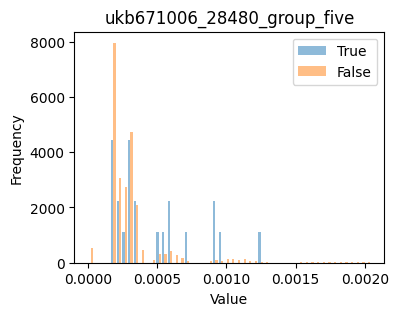

ATE = -0.0873764149591632
Warnings= Maximum Likelihood optimization failed to converge. Check mle_retvals



In [103]:
# Categorical variables
pheno_list_categorical = [
"ukb671006_28474_cluster",
"ukb671006_28475_group_eid_old",
"ukb671006_28476_abnormal_group_eid_old",
"ukb671006_28480_group_five",]

result_categorical = [["Phenotype", "Value", "ATE", "Warning"]]

for pheno in pheno_list_categorical:
    print("Phenotype =", pheno)
    
    for z_subdivision in set(df_comparison[pheno]):
        print("subdivision =", z_subdivision)
        ATE, warnings_messages = func_propensity_ATE(df_comparison.to_pandas(),
                              x_names=['ukb671006_28472_age','ukb671006_28473_sex', 
                                       'ukb671006_28449_day_num', 'ukb671006_28471_continuous_day'],
                              y_name='cancer',
                              z_name=pheno,
                              z_subdivision=z_subdivision
        )
            
        print("ATE =", ATE)
        if warnings_messages != "None":
            print("Warnings=", warnings_messages)
        else:
            pass

        result_categorical.append([pheno, z_subdivision, ATE, warnings_messages])
        print()
    
FILE_OUT = os.path.join(DIR_OUT, "AdjustedTreatmentEffect_categorical.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(result_categorical)

Phenotype = ukb671006_28450_ST_long_mean


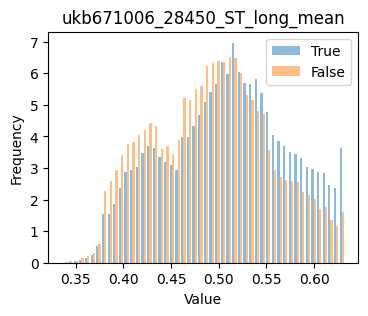

ATE = -0.00033726813440217857

Phenotype = ukb671006_28451_ST_long_sd


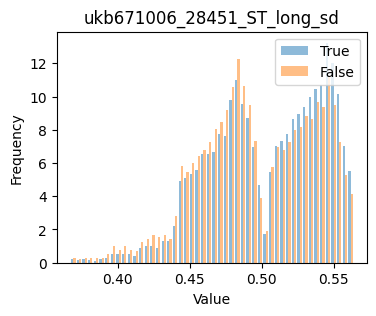

ATE = 7.161208795699453e-05

Phenotype = ukb671006_28452_WT_long_mean


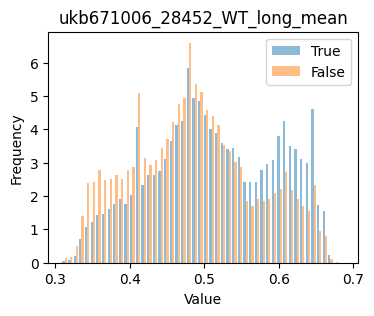

ATE = 0.0061282200595172455

Phenotype = ukb671006_28453_WT_long_sd


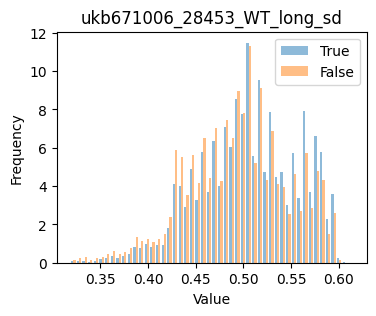

ATE = -0.006705419337262113

Phenotype = ukb671006_28454_ST_short_mean


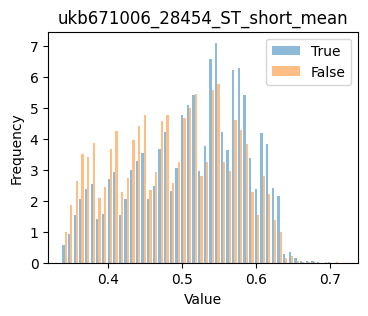

ATE = 0.0020841443965672474

Phenotype = ukb671006_28455_ST_short_sd


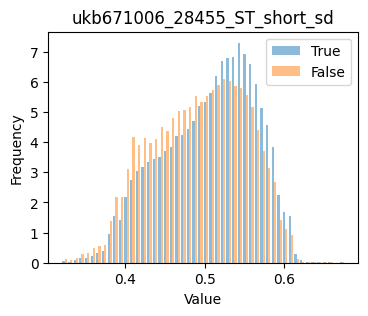

ATE = -0.0003602193746466472

Phenotype = ukb671006_28456_WT_short_mean


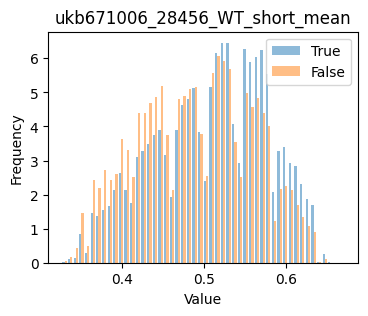

ATE = 0.004525889639455254

Phenotype = ukb671006_28457_WT_short_sd


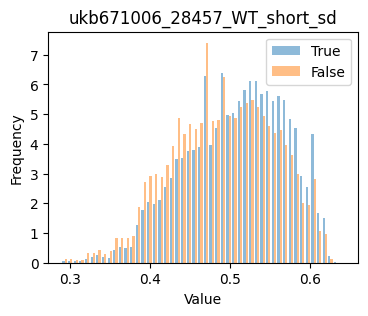

ATE = -0.01494769912486118

Phenotype = ukb671006_28458_long_window_len_mean


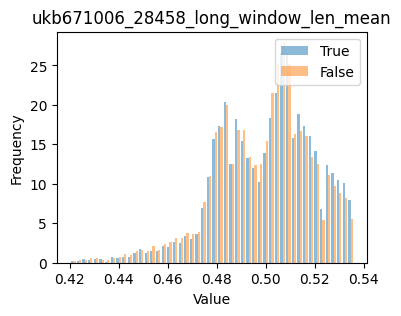

ATE = 0.007557266811262266

Phenotype = ukb671006_28459_long_window_len_sd


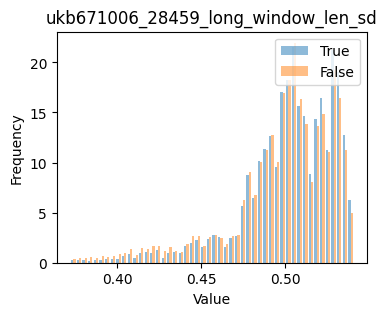

ATE = -0.0043283160923445795

Phenotype = ukb671006_28460_long_window_num_mean


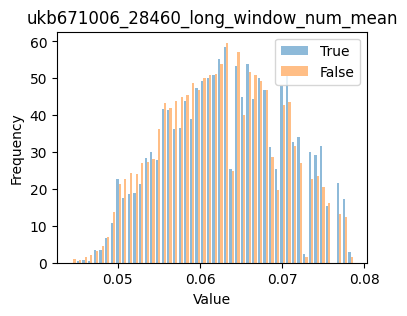

ATE = 0.012515313414074164

Phenotype = ukb671006_28461_long_window_num_sd


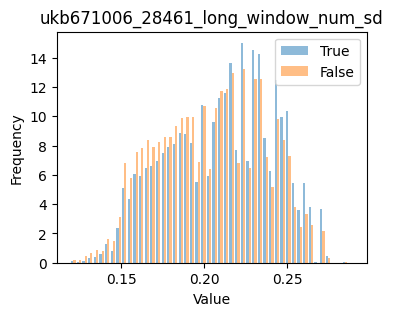

ATE = 0.002378614881057079

Phenotype = ukb671006_28462_short_window_len_mean


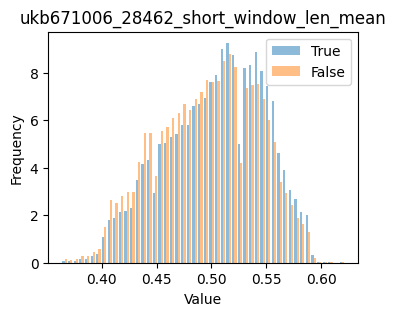

ATE = 0.03518882686520157

Phenotype = ukb671006_28463_short_window_len_sd


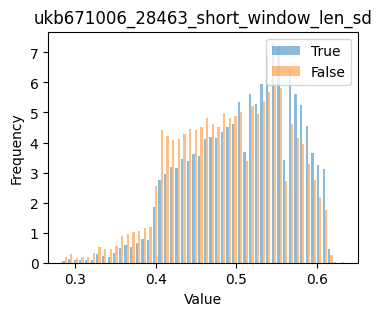

ATE = 0.006107462010132957

Phenotype = ukb671006_28464_short_window_num_mean


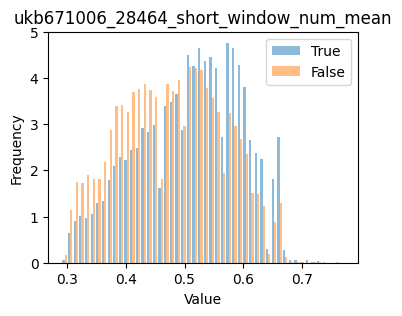

ATE = 0.0019746911378064544

Phenotype = ukb671006_28465_short_window_num_sd


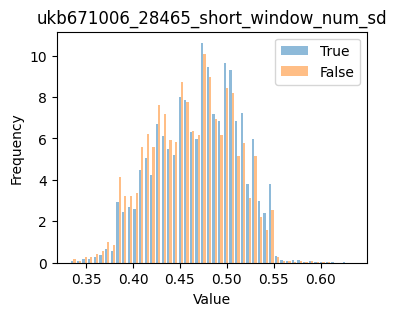

ATE = 0.016182511699306755

Phenotype = ukb671006_28466_phase_mean


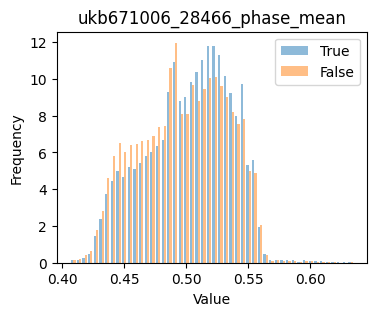

ATE = -0.07160988616629826

Phenotype = ukb671006_28467_phase_sd


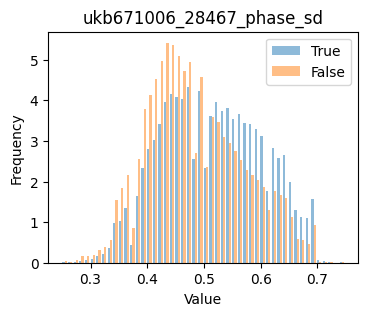

ATE = 0.004395158695724894

Phenotype = ukb671006_28468_max_period


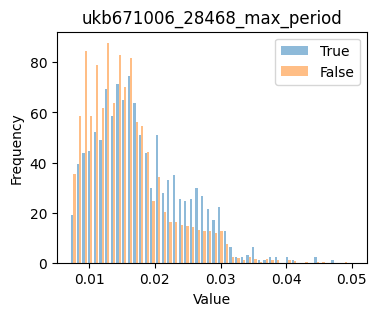

ATE = -0.015107697573710749

Phenotype = ukb671006_28469_amplitude


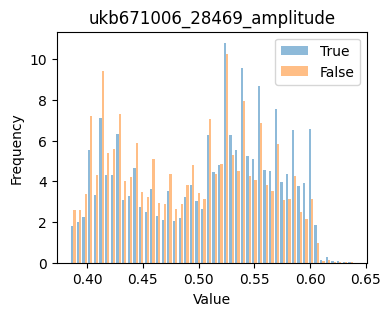

ATE = 0.006382511548254405

Phenotype = ukb671006_28470_sleep_percentage


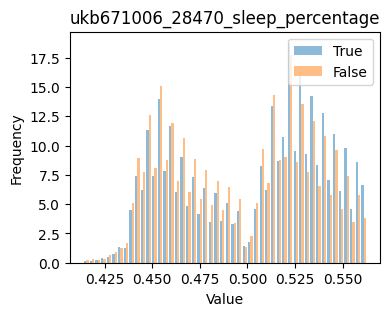

ATE = 0.0034941489840223453

Phenotype = ukb671006_28472_age
ATE = -999999
Warnings= Perfect separation detected, results not available

Phenotype = ukb671006_24430_90010-0.0_days
ATE = -999999
Warnings= Perfect separation detected, results not available

Phenotype = earliest_cancer_days
ATE = -999999
Warnings= Perfect separation detected, results not available



In [104]:
# Continuous variables
pheno_list_continuous = [
"ukb671006_28450_ST_long_mean",
"ukb671006_28451_ST_long_sd",
"ukb671006_28452_WT_long_mean",
"ukb671006_28453_WT_long_sd",
"ukb671006_28454_ST_short_mean",
"ukb671006_28455_ST_short_sd",
"ukb671006_28456_WT_short_mean",
"ukb671006_28457_WT_short_sd",
"ukb671006_28458_long_window_len_mean",
"ukb671006_28459_long_window_len_sd",
"ukb671006_28460_long_window_num_mean",
"ukb671006_28461_long_window_num_sd",
"ukb671006_28462_short_window_len_mean",
"ukb671006_28463_short_window_len_sd",
"ukb671006_28464_short_window_num_mean",
"ukb671006_28465_short_window_num_sd",
"ukb671006_28466_phase_mean",
"ukb671006_28467_phase_sd",
"ukb671006_28468_max_period",
"ukb671006_28469_amplitude",
"ukb671006_28470_sleep_percentage",
"ukb671006_28472_age",
"ukb671006_24430_90010-0.0_days",
"earliest_cancer_days",
]

result_continuous = [["Phenotype", "Value", "ATE", "Warning"]]

for pheno in pheno_list_continuous:
    print("Phenotype =", pheno)
    ATE, warnings_messages = func_propensity_ATE(df_comparison.to_pandas(),
                          x_names=['ukb671006_28472_age','ukb671006_28473_sex', 
                                   'ukb671006_28449_day_num', 'ukb671006_28471_continuous_day'],
                          y_name='cancer',
                          z_name=pheno,
                          z_subdivision=""
        )

    print("ATE =", ATE)
    if warnings_messages != "None":
        print("Warnings=", warnings_messages)
    else:
        pass

    result_continuous.append([pheno, "higher_half", ATE, warnings_messages])
    print()
    
    
FILE_OUT = os.path.join(DIR_OUT, "AdjustedTreatmentEffect_continuous.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(result_continuous)

In [101]:
result_all = result_categorical + result_continuous[1:]
FILE_OUT = os.path.join(DIR_OUT, "AdjustedTreatmentEffect_all.csv")
with open(FILE_OUT, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(result_all)

## Propensity score matching-based stat tests

In [ ]:
        # Perform a two-sample t-test to test for significant differences between the two distributions
        mann_stat, p_value = stats.mannwhitneyu(np_before, np_after, alternative='two-sided')


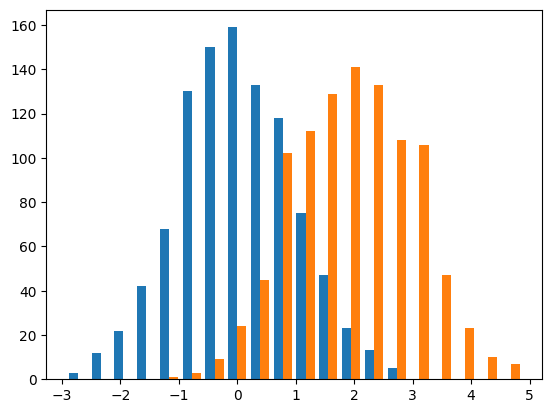

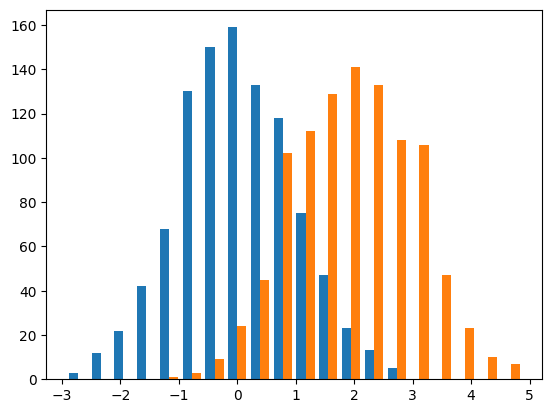

In [114]:
import polars as pl
import numpy as np

# Sample data
data_1 = {'col1': np.random.normal(0, 1, 1000)}
data_2 = {'col1': np.random.normal(2, 1, 1000)}

# Convert data to Polars DataFrames
df_1 = pl.DataFrame(data_1)
df_2 = pl.DataFrame(data_2)

# Get the maximum row count between the two DataFrames
max_row_count = max(len(df_1), len(df_2))

# Calculate weights for downsampling based on the row count
weights_1 = len(df_1) / max_row_count
weights_2 = len(df_2) / max_row_count

# Downsample the DataFrames with the calculated weights
df_1_new = df_1.sample(frac=weights_1)
df_2_new = df_2.sample(frac=weights_2)

plt.hist([df_1["col1"], df_2["col1"]], bins=20)
plt.show()
plt.hist([df_1_new["col1"], df_2_new["col1"]], bins=20)
plt.show()